In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
from IPython.display import HTML

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


# IV_new_2: Scaled BV Parameters

In [4]:
# environment parameters
R=8.314
F=96485.0

oT =700+273.15      #Temperature oxidant (K)
fT =700+273.15      #Temperature fuel (K)
Tk=(oT+fT)/2.0
Tc=Tk-273.0

pO2air=0.3          #Air side partial pressure O2 (atm)
pN2air =0.7         #Air side partial pressure N2 (atm)
# pH2 = 0.4375        #Fuel side partial pressure H2 (atm)
# pH2O =0.3125        #Fuel side partial pressure H2O (atm)
# pCO=0.0625          #Fuel side partial pressure CO (atm)
# pCO2=0.0625         #Fuel side partial pressure CO2 (atm)
# pCH4=0.125          #Fuel side partial pressure CH4 (atm)
# pN2=0.0             #Fuel side partial pressure N2 (atm)
pH2 = 0.97        #Fuel side partial pressure H2 (atm)
pH2O =0.03        #Fuel side partial pressure H2O (atm)
pCO=0.0         #Fuel side partial pressure CO (atm)
pCO2=0.0         #Fuel side partial pressure CO2 (atm)
pCH4=0.0          #Fuel side partial pressure CH4 (atm)
pN2=0.0             #Fuel side partial pressure N2 (atm)
pSys=1.0            #System pressure (atm)  

# fuel cell property parameters
de_a = 0.61           #diameter of electrically conducting particles for anode 0.2-0.8
ne_a = 0.2              #number fraction of electrically conducting particles for anode 0.2-0.6
alpha_a = 0.475/0.61      #the particle size ratio of ionic to electronic conducting particles for anode 0.5-2.0
de_c = de_a          #**   #for cathode
ne_c = ne_a           #**  #for cathode
alpha_c = alpha_a     #**  #for cathode
d0_am = 0.228 # pore diameter [microm]
d0_cm = d0_am

# adjustable parameters for B-V loss (starting with these for optimization)
BV_alpha = 0.43236 #0.43236/3 **
BV_prexp = 5639 #**
BV_Eact = 79616 #**

In [6]:
#IV MODEL Updated hypersine formula for BV
# updated I-V relationship by considering Knudsen Dissuion (calculated from pore size)
def IV_new_2(oT,fT,J,pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
             BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
             DsurfH2th1=0.1, DsurfH2th2=4.51e-5,Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10):
    #-- B Koeppel
    #-- 10-13-2014
    #--
    #-------------------------------------------------------------------
    #--                                                               --
    #--       VoltageValue()                                          --
    #--                                                               --
    #--       V-I performance based on spreadsheet EC model           --
    #--       Updated to include SOA performance                      --
    #--                                                               --
    #-------------------------------------------------------------------
    #--
    #-- Available Local Inputs From SOFC-MP
#    oT =700.0                       #Temperature oxidant (K)
#    fT =700.0                        #Temperature fuel (K)
#    J=0.01                         # Current density (A/cm2)
#    pO2air=0.3                    # Air side partial pressure O2 (atm)
#    pN2air =0.7                    #Air side partial pressure N2 (atm)
#    pH2 = 0.1                       #Fuel side partial pressure H2 (atm)
#    pH2O =0.9                      #Fuel side partial pressure H2O (atm)
#    pCO=0.0                       # Fuel side partial pressure CO (atm)
#    pCO2=0.0                      # Fuel side partial pressure CO2 (atm)
#    pCH4=0.0                      # Fuel side partial pressure CH4 (atm)
#    pN2=0.0                       # Fuel side partial pressure N2 (atm)
#    pSys=1.0                      #System pressure (atm)
    #--nActiveCell               # Cell number
    #--   DistanceFromTheEdge        Distance along path (m)
    #--   DistanceFromTheEdgeRatio   Relative distance along the path 
    #--
    #-- Required Subroutine Outputs
    #--   Z                          Voltage (V)
    #--
    #------------------------------------------------------------------
    #--
    #-- User-Assigned Geometry/Material Inputs
    #--   th_a       Thickness anode (microns)
    #--   th_e       Thickness electrolyte (microns)
    #--   th_c       Thickness cathode (microns)
    #--   th_ic      Thickness interconnect (microns)
    #--   por_a      Porosity anode (%)
    #--   por_c      Porosity cathode (%)
    #--   tort_a     Tortuosity anode
    #--   tort_c     Tortuosity cathode
    #--   BV_alpha   Butler-Volmer 'alpha' constant
    #--   BV_prexp   Butler-Volmer pre-exponential constant
    #--   BV_Eact    Butler-Volmer activation energy
    #--   R_cont     Contact resistance
    #--
    #-- User-Assigned Constants/Conversions
    #--   R          Ideal gas constant
    #--   F          Faraday's constant
    #--   atm2Pa     Conversion for pressure atm -> Pa
    #--   mic2m      Conversion for length micron -> m
    #------------------------------------------------------------------
    #--
    #function VoltageValue()
    #--
    #--J=-J
    #-- Assign Constants/Conversions
    R=8.3145
    F=96485.0
    atm2Pa=101325.0
    mic2m=1.0e-6
    #--
    #-- Assign Flags
    BVflag=0        #-- 0=old method, 1=pressurized method
    #--
    #-- Assign Geometry/Material Data
    th_a=           300.0 #
#     th_e=           10.0 #
    th_c=           30.0 #
    th_ic=          500.0 #
    por_a=          40.0 #
    por_c=          40.0 #
    tort_a=         2.5 #
    tort_c=         2.5 #
#     BV_alpha=       0.43236
#     BV_prexp=       5639.0
#     BV_Eact=        79616.0
#     R_cont=         0.0
    BV_alpha2a=     0.44 # initial guess for symmetric factor
    BV_prexp2a=     1.43E+04
    BV_Eact2a=      8.00E+04
    BV_gamma2a=     0.5
    BV_alpha2f=     9.01
    BV_prexp2f=     1.31E+07
    BV_Eact2f=      8.00E+04
    BV_gamma2f=     0.133
#     V_loss=         0.0
    #--
    #%-- Compute the local cell temperature
    #------------------------------------------------------------------
    Tk=(oT+fT)/2.0
    Tc=Tk-273.0
    #--
    #%-- Compute the Nernst open circuit voltage
    #------------------------------------------------------------------
    Keq_dHo=-56930.0
    Keq_A=6.75
    Keq_B=-0.64
    Keq_C=-0.08
    Keq_L=-8.74
    Keq_dG=Keq_dHo+Keq_A*Tk*math.log10(Tk)+Keq_B*Tk*Tk/1000+Keq_C*100000/Tk+Keq_L*Tk
    Kequib=math.exp(-Keq_dG*4.184/R/Tk)
    pO2anode=(pH2O/Kequib/pH2)**2
    Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    #--
    #%-- Compute the ohmic polarization
    #------------------------------------------------------------------
    #-- Compute the electrolyte conductivity
    s_eA=8.588e-10
    s_eB=-1.101e-6
    s_eC=4.679e-4
    s_eD=-0.0654
    s_e=s_eA*Tc**3+s_eB*Tc**2+s_eC*Tc+s_eD
    #%-- Compute the interconnect conductivity
    s_icA=0.069
    s_icB=70.9
    s_ic=1000000.0/(s_icA*Tc+s_icB)
    #%-- Compute the cathode conductivity
    s_cA=575955.0
    s_cEa=0.117
    s_c=(s_cA/Tk)*math.exp(-s_cEa/0.00008617/Tk)*(1.0-(0.018*por_c))
    #%-- Compute the anode conductivity
    s_aA=1000
    s_a=s_aA*(1.0-(0.018*por_a))
    #%-- Compute the effective cell resistivity
    Ri=R_cont+(th_e/s_e+th_a/s_a+th_ic/s_ic+th_c/s_c)*0.0001
    #%-- Compute the total ohmic loss
    Ohmic=Ri*J
    #--
    #%-- Compute the activation polarization (old method or new pressurized method)
    #------------------------------------------------------------------
    if BVflag==0:
    #  -- Old method###### BV_prexp(scaled) = BV_prexp/10000
    ####### BV_Eact(scaled) = BV_Eact/R/T
        i0=BV_prexp*math.exp(-BV_Eact)
        BV=(R*Tk/BV_alpha/F)*math.log((J/2.0/(i0*10000))+math.sqrt((J/2.0/(i0*10000))**2+1))
    else:
    #  -- New method
        ioeff_f=BV_prexp2f*math.exp(-BV_Eact2f/R/Tk)*pO2anode**BV_gamma2f
        ioeff_a=BV_prexp2a*math.exp(-BV_Eact2a/R/Tk)*pO2air**BV_gamma2a
        eta_f=R*Tk/BV_alpha2f/F*math.log((J/2.0/ioeff_f)+math.sqrt((J/2.0/ioeff_f)**2+1))
        eta_a=R*Tk/BV_alpha2a/F*math.log((J/2.0/ioeff_a)+math.sqrt((J/2.0/ioeff_a)**2+1))
        BV=eta_f+eta_a
    
    #--
    #%-- Compute the diffusion coefficients
    #------------------------------------------------------------------
    #-- Make 0.0 species non-zero to make equations defined
    if pCO<=0 :
        pCOc=1e-16
    else:
        pCOc=pCO
    
    if pCO2<=0 :
        pCO2c=1e-16
    else:
        pCO2c=pCO2
    
    Ptotal=pH2+pH2O+pCOc+pCO2c+pN2+pCH4
    H2_mf=pH2/Ptotal
    H2O_mf=pH2O/Ptotal
    CO_mf=pCOc/Ptotal
    CO2_mf=pCO2c/Ptotal
    N2_mf=pN2/Ptotal
    CH4_mf=pCH4/Ptotal
    #-- Diffusion constants (empirical radii and molecular weights)
    H2i=1.92
    H2Oi=2.33
    COi=2.66
    CO2i=3.0
    N2i=2.62
    O2i=2.55
    CH4i=2.9
    H2ii=2.0 #unit [g/mol]
    H2Oii=18.0 #unit [g/mol]
    COii=28.0 #unit [g/mol]
    CO2ii=44.0 #unit [g/mol]
    N2ii=28.0 #unit [g/mol]
    O2ii=32.0 #unit [g/mol]
    CH4ii=16.0 #unit [g/mol]
    #%-- Compute anode binary diffusion constants
    H2H2O=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/H2Oii)/((H2i+H2Oi)**2)
    H2CO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/COii)/((H2i+COi)**2)
    H2CO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CO2ii)/((H2i+CO2i)**2)
    H2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/N2ii)/((H2i+N2i)**2)
    H2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CH4ii)/((H2i+CH4i)**2)
    O2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/O2ii+1/N2ii)/((O2i+N2i)**2)
    H2OCO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/COii)/((H2Oi+COi)**2)
    H2OCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CO2ii)/((H2Oi+CO2i)**2)
    H2ON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/N2ii)/((H2Oi+N2i)**2)
    H2OCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CH4ii)/((H2Oi+CH4i)**2)
    N2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/N2ii+1/CH4ii)/((N2i+CH4i)**2)
    COCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CO2ii)/((COi+CO2i)**2)
    CON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/N2ii)/((COi+N2i)**2)
    COCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CH4ii)/((COi+CH4i)**2)
    CO2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/N2ii)/((CO2i+N2i)**2)
    CO2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/CH4ii)/((CO2i+CH4i)**2)
    #%-- Compute anode unitary diffusion constants
    H2_UD=(1-H2_mf)/(H2O_mf/H2H2O+CO_mf/H2CO+CO2_mf/H2CO2+N2_mf/H2N2+CH4_mf/H2CH4)
    H2O_UD=(1-H2O_mf)/(H2_mf/H2H2O+CO_mf/H2OCO+CO2_mf/H2OCO2+N2_mf/H2ON2+CH4_mf/H2OCH4)
    CO_UD=(1-CO_mf)/(H2_mf/H2CO+H2O_mf/H2OCO+CO2_mf/COCO2+N2_mf/CON2+CH4_mf/COCH4)
    CO2_UD=(1-CO2_mf)/(H2_mf/H2CO2+H2O_mf/H2OCO2+CO_mf/COCO2+N2_mf/CO2N2+CH4_mf/CO2CH4)
    N2_UD=(1-N2_mf)/(H2_mf/H2N2+H2O_mf/H2ON2+CO_mf/CON2+CO2_mf/CO2N2+CH4_mf/N2CH4)
    CH4_UD=(1-CH4_mf)/(H2_mf/H2CH4+H2O_mf/H2OCH4+CO_mf/COCH4+CO2_mf/CO2CH4+N2_mf/N2CH4)
    #%-- Compute anode adsorption and surface diffusion modifications
    area_H2=math.pi*(H2i*10**-10)**2
    area_H2O=math.pi*(H2Oi*10**-10)**2
    area_CO=math.pi*(COi*10**-10)**2
    area_CO2=math.pi*(CO2i*10**-10)**2
    area_N2=math.pi*(N2i*10**-10)**2
    area_O2=math.pi*(O2i*10**-10)**2
    area_CH4=math.pi*(CH4i*10**-10)**2
    pres_H2=max(0,pH2-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2_UD*por_a/100)))
    pres_H2O=max(0,pH2O+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2O_UD*por_a/100)))
    pres_CO=max(0,pCOc-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO_UD*por_a/100)))
    pres_CO2=max(0,pCO2c+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO2_UD*por_a/100)))
    pres_N2=max(0,pN2)
    pres_O2=max(0,pO2anode)
    pres_CH4=max(0,pCH4)
    Qev_H2=0.425
    Qev_H2O=0.549
    Qev_CO=0.5
    Qev_CO2=0.5
    Qev_N2=0.5
    Qev_O2=0.5
    Qev_CH4=0.5
    bP_H2=6.023*10**23*area_H2*10**-13/math.sqrt(2*math.pi*R*Tk*H2ii)*math.exp(Qev_H2/(0.026*Tk/298))*pres_H2
    bP_H2O=6.023*10**23*area_H2O*10**-13/math.sqrt(2*math.pi*R*Tk*H2Oii)*math.exp(Qev_H2O/(0.026*Tk/298))*pres_H2O
    bP_CO=6.023*10**23*area_CO*10**-13/math.sqrt(2*math.pi*R*Tk*COii)*math.exp(Qev_CO/(0.026*Tk/298))*pres_CO
    bP_CO2=6.023*10**23*area_CO2*10**-13/math.sqrt(2*math.pi*R*Tk*CO2ii)*math.exp(Qev_CO2/(0.026*Tk/298))*pres_CO2
    bP_N2=6.023*10**23*area_N2*10**-13/math.sqrt(2*math.pi*R*Tk*N2ii)*math.exp(Qev_N2/(0.026*Tk/298))*pres_N2
    bP_O2=6.023*10**23*area_O2*10**-13/math.sqrt(2*math.pi*R*Tk*O2ii)*math.exp(Qev_O2/(0.026*Tk/298))*pres_O2
    bP_CH4=6.023*10**23*area_CH4*10**-13/math.sqrt(2*math.pi*R*Tk*CH4ii)*math.exp(Qev_CH4/(0.026*Tk/298))*pres_CH4
    bP_sum=bP_H2+bP_H2O+bP_CO+bP_CO2+bP_N2+bP_O2+bP_CH4
    cov_H2=bP_H2/(1+bP_sum)
    cov_H2O=bP_H2O/(1+bP_sum)
    cov_CO=bP_CO/(1+bP_sum)
    cov_CO2=bP_CO2/(1+bP_sum)
    cov_N2=bP_N2/(1+bP_sum)
    cov_O2=bP_O2/(1+bP_sum)
    cov_CH4=bP_CH4/(1+bP_sum)
    cov_sum=cov_H2+cov_H2O+cov_CO+cov_CO2+cov_N2+cov_O2+cov_CH4
    fij_H2=cov_H2/cov_sum
    fij_H2O=cov_H2O/cov_sum
    fij_CO=cov_CO/cov_sum
    fij_CO2=cov_CO2/cov_sum
    fij_N2=cov_N2/cov_sum
    fij_O2=cov_O2/cov_sum
    fij_CH4=cov_CH4/cov_sum
#     DsurfH2th1=0.1
#     DsurfH2th2=4.51e-5
    D_H2=H2_UD**fij_H2*((DsurfH2th1**(1-fij_H2)*DsurfH2th2**fij_H2)/(1-fij_H2))**(1-fij_H2)
    D_H2O=H2O_UD**fij_H2O*(10**-4)**(1-fij_H2O)
    D_CO=CO_UD**fij_CO*(10**-4)**(1-fij_CO)
    D_CO2=CO2_UD**fij_CO2*(10**-4)**(1-fij_CO2)
    D_N2=N2_UD**fij_N2*(10**-4)**(1-fij_N2)
    D_O2=O2N2**fij_O2*(10**-4)**(1-fij_O2)
    D_CH4=CH4_UD**fij_CH4*(10**-4)**(1-fij_CH4)
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
        #-- Compute the effective Knudsen diffusion coefficient
        d0_a=d0_am*(10**-6)
        DeffH2_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(H2ii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffH2O_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(H2Oii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffCO_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(COii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffCO2_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(CO2ii*10**(-3)))*por_a/tort_a*0.01*10**4

        d0_c=d0_cm*(10**-6)
        DeffO2_K=1/3*d0_c*math.sqrt(8*R*Tk/math.pi/(O2ii*10**(-3)))*por_c/tort_c*0.01*10**4
    #---------------------------------------------------------------------------------------------------------------------
    #%-- Compute the cathode concentration polarization
    #------------------------------------------------------------------
    Deffc=0.01*por_c*O2N2/tort_c
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
#         print('Cathode: O2 ',Deffc, 'vs.', DeffO2_K, '[cm2/s]')
        Deffc=(Deffc*DeffO2_K)/(Deffc+DeffO2_K)
    #---------------------------------------------------------------------------------------------------------------------
    ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(pSys/(pSys-pO2air))
    #--ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(Ptotal/(Ptotal-pO2air))
    Cath=(R*Tk/4.0/F)*math.log(1.0-(J/ics))
    #--
    #%-- Compute the anode concentration polarization
    #------------------------------------------------------------------
    DeffH2=D_H2
    DeffH2O=0.01*H2O_UD*por_a/tort_a
    DeffCO=0.01*CO_UD*por_a/tort_a
    DeffCO2=0.01*CO2_UD*por_a/tort_a
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
#         print('Anode: H2 Dffe_normal ',DeffH2, 'vs. Deff_Knu', DeffH2_K, '[cm2/s]')
#         print('Anode: H2O Dffe_normal ',DeffH2O, 'vs. Deff_Knu', DeffH2O_K, '[cm2/s]')
#         print('Anode: CO Dffe_normal ',DeffCO, 'vs. Deff_Knu', DeffCO_K, '[cm2/s]')
#         print('Anode: CO2 Dffe_normal ',DeffCO2, 'vs. Deff_Knu', DeffCO2_K, '[cm2/s]')

        DeffH2=(DeffH2*DeffH2_K)/(DeffH2+DeffH2_K)
        DeffH2O=(DeffH2O*DeffH2O_K)/(DeffH2O+DeffH2O_K)
        DeffCO=(DeffCO*DeffCO_K)/(DeffCO+DeffCO_K)
        DeffCO2=(DeffCO2*DeffCO2_K)/(DeffCO2+DeffCO2_K)
    #---------------------------------------------------------------------------------------------------------------------
    alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
    blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
    clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
    dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
    #-- Adjust calculation for iteration case of too high current requested
    if J>(alim+clim) :
        Jcalc=J
    else:
        Jcalc=J
    
    OPa_A=(Jcalc+blim+dlim)/blim/dlim
    OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
    OPa_C=(Jcalc-alim-clim)/alim/clim
    holdA1=OPa_A
    holdB1=OPa_B
    holdC1=OPa_C
    stabcheck=OPa_B**2-4.0*OPa_A*OPa_C
    stabcheck2=(-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A
#     print('alim: ', alim)
#     print('blim: ', blim)
#     print('clim: ', clim)
#     print('dlim: ', dlim)
#     print('OPa_A: ', OPa_A)
#     print('OPa_B: ', OPa_B)
#     print('OPa_C: ', OPa_C)
#     print('stabcheck: ', stabcheck)
#     print('stabcheck2: ', stabcheck2)
    if stabcheck>0 :
        if stabcheck2>0 :
            # print('stabcheck>0 and stabcheck2>0')
            Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
            holdA2=0
            holdB2=0
            holdC2=0
            goober=1
#         print('DeffH2: ', DeffH2)
        else:
            # print('stabcheck>0 and stabcheck2<0')
            DeffH2=0.01*H2_UD*por_a/tort_a
            DeffH2O=0.01*H2O_UD*por_a/tort_a
            DeffCO=0.01*CO_UD*por_a/tort_a
            DeffCO2=0.01*CO2_UD*por_a/tort_a
            #---------------------------------------------------------------------------------------------------------------------
            if Fkn==True:
                DeffH2=(DeffH2*DeffH2_K)/(DeffH2+DeffH2_K)
                DeffH2O=(DeffH2O*DeffH2O_K)/(DeffH2O+DeffH2O_K)
                DeffCO=(DeffCO*DeffCO_K)/(DeffCO+DeffCO_K)
                DeffCO2=(DeffCO2*DeffCO2_K)/(DeffCO2+DeffCO2_K)
            #---------------------------------------------------------------------------------------------------------------------
    #         print('DeffH2: ', DeffH2)
            alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
            blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
            clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
            dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
            OPa_A=(Jcalc+blim+dlim)/blim/dlim
            OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
            OPa_C=(Jcalc-alim-clim)/alim/clim
            holdA2=OPa_A
            holdB2=OPa_B
            holdC2=OPa_C
            Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
            goober=2
    
    #--
    #%-- Compute the final voltage result
    #------------------------------------------------------------------
   # print(Voc,Ohmic,BV,Cath)
    V=(Voc-Ohmic-BV+Cath+Anod)+V_loss #this is the original one for SOFC
    #--file=io.open("vdetails.dat","a")
    #V=(Voc+Ohmic+BV-Cath-Anod)+V_loss #SOEC proton
    #Z=V #*1.1+0.05
  #  print(V,"(V)=",Voc,"(Voc)+",Ohmic,"(Ohmic)+",BV,"(BV)-",Cath,"(Cath)-",Anod,"Anod)")
   
    #--Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    #--file:write(Voc," ",Ohmic," ",BV," ",Cath," ",Anod," ",pN2air," ",pH2," ",pH2O," ",pCO," ",pCO2," ",pCH4,"\n")
    #--pO2anode=(pH2O/Kequib/pH2)**2
    #--file:write(Voc,"=",pO2air,"/",pO2anode,"  =",pH2O,"/",Kequib,"/",pH2,"\n")
    #--file:close()
    #--
    #-- return the voltage value
    return(V,Voc,Ohmic,BV,Cath,Anod)

     fun: 0.008111437034163773
     jac: array([-9.85954888e-04, -1.19485194e-05,  1.96625479e-05, -3.98213277e-04,
        1.86109450e-04, -1.80131639e-04, -6.71017915e-06])
 message: 'Optimization terminated successfully.'
    nfev: 163
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([ 0.7       ,  1.70214263, 11.66094414, -0.09267377,  0.27081364,
        0.58679365,  0.28259966])


Text(0.5, 1.0, 'EXP. VS. IV_new')

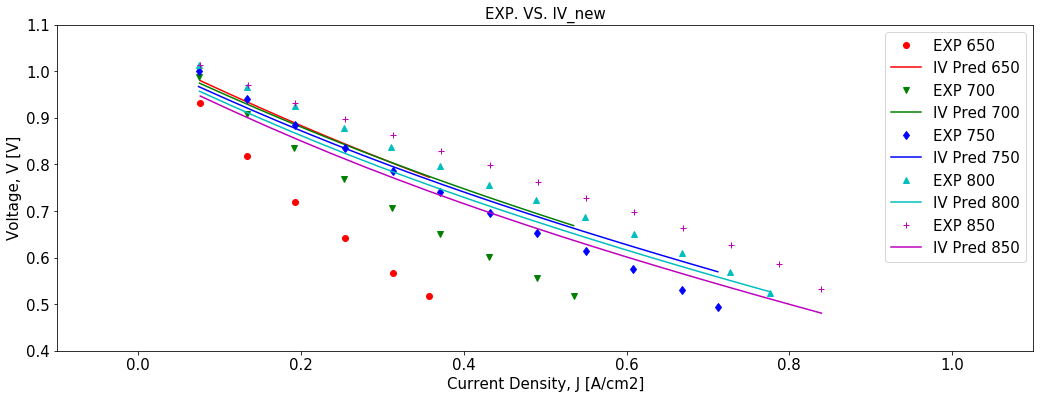

In [10]:
# comparison between JHM-2017 experimental data and   
#initilize and optimize
param_guess = (0.49, 3500/10000, 100000/R/Tk, 0.0, 0.0, 0.28, 0.28)

# BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
# DsurfH2th1=0.1, DsurfH2th2=4.51e-5,
# Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10

Tlist = [650, 700, 750, 800, 850]
th_e = 10
param_fixed = [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys]

def objective_function_JM(param_guess, param_fixed):  
    
    [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys] = param_fixed

    filename = './ExperimentalData/JM2017/AllData_JM.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    x = data[:,0]
    y_exp = data[:,1]
    Toper = data[:, 2]

    y_model = np.zeros(len(y_exp))
    for j in range(len(y_exp)):
        y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_new_2(Toper[j]+273.15,Toper[j]+273.15,x[j],
                                                           pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                           param_guess[0], param_guess[1], param_guess[2],
                                                           param_guess[3], param_guess[4], 0.1, 4.51e-5,
                                                             True,param_guess[5],param_guess[6])
    #rmse = mean_squared_error(y_exp, y_model, squared=False)
    rmse = mean_squared_error(y_exp, y_model)
    return rmse

obj_guess = objective_function_JM(param_guess, param_fixed)
bnds = ((0.3, 0.7), (0, None), (0, None), (None, 0), (0, None), (0.2, 2.0), (0.2, 2.0))
result = minimize(objective_function_JM, param_guess, args = (param_fixed), method = 'SLSQP', bounds = bnds)
print(result)

# plot and comparison
markerlist = ['o', 'v', 'd', '^', '+']
colorlist = ['r', 'g', 'b', 'c', 'm']
plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './ExperimentalData/JM2017/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # initialize Jlist and Vlist
    Jlist=np.linspace(np.amin(data[:,0]), np.amax(data[:,0]), num=20)   #Current density, unit [A/cm2]
    Vlist = np.zeros(20)
    
    # plot pred data
    for j in range(20):
        Vlist[j], Voc, Ohmic, BV, Cath, Anode = IV_new_2(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                       result.x[0],result.x[1],result.x[2],
                                                       result.x[3], result.x[4], 0.1, 4.51e-5,
                                                       True,result.x[5],result.x[6])
    plt.plot(Jlist, Vlist, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
plt.xlim(-0.1, 1.1)
plt.ylim(0.4, 1.1)
# ymin, ymax = plt.ylim()
# plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)

# IV_new_3: hyperbolic sine

In [ ]:
#IV MODEL Hyperbolicc sine
# updated I-V relationship by considering Knudsen Dissuion (calculated from pore size)
def IV_new_3(oT,fT,J,pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
             BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
             DsurfH2th1=0.1, DsurfH2th2=4.51e-5,Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10):
    #-- B Koeppel
    #-- 10-13-2014
    #--
    #-------------------------------------------------------------------
    #--                                                               --
    #--       VoltageValue()                                          --
    #--                                                               --
    #--       V-I performance based on spreadsheet EC model           --
    #--       Updated to include SOA performance                      --
    #--                                                               --
    #-------------------------------------------------------------------
    #--
    #-- Available Local Inputs From SOFC-MP
#    oT =700.0                       #Temperature oxidant (K)
#    fT =700.0                        #Temperature fuel (K)
#    J=0.01                         # Current density (A/cm2)
#    pO2air=0.3                    # Air side partial pressure O2 (atm)
#    pN2air =0.7                    #Air side partial pressure N2 (atm)
#    pH2 = 0.1                       #Fuel side partial pressure H2 (atm)
#    pH2O =0.9                      #Fuel side partial pressure H2O (atm)
#    pCO=0.0                       # Fuel side partial pressure CO (atm)
#    pCO2=0.0                      # Fuel side partial pressure CO2 (atm)
#    pCH4=0.0                      # Fuel side partial pressure CH4 (atm)
#    pN2=0.0                       # Fuel side partial pressure N2 (atm)
#    pSys=1.0                      #System pressure (atm)
    #--nActiveCell               # Cell number
    #--   DistanceFromTheEdge        Distance along path (m)
    #--   DistanceFromTheEdgeRatio   Relative distance along the path 
    #--
    #-- Required Subroutine Outputs
    #--   Z                          Voltage (V)
    #--
    #------------------------------------------------------------------
    #--
    #-- User-Assigned Geometry/Material Inputs
    #--   th_a       Thickness anode (microns)
    #--   th_e       Thickness electrolyte (microns)
    #--   th_c       Thickness cathode (microns)
    #--   th_ic      Thickness interconnect (microns)
    #--   por_a      Porosity anode (%)
    #--   por_c      Porosity cathode (%)
    #--   tort_a     Tortuosity anode
    #--   tort_c     Tortuosity cathode
    #--   BV_alpha   Butler-Volmer 'alpha' constant
    #--   BV_prexp   Butler-Volmer pre-exponential constant
    #--   BV_Eact    Butler-Volmer activation energy
    #--   R_cont     Contact resistance
    #--
    #-- User-Assigned Constants/Conversions
    #--   R          Ideal gas constant
    #--   F          Faraday's constant
    #--   atm2Pa     Conversion for pressure atm -> Pa
    #--   mic2m      Conversion for length micron -> m
    #------------------------------------------------------------------
    #--
    #function VoltageValue()
    #--
    #--J=-J
    #-- Assign Constants/Conversions
    R=8.3145
    F=96485.0
    
    atm2Pa=101325.0
    mic2m=1.0e-6
    #--
    #-- Assign Flags
    BVflag=0        #-- 0=old method, 1=pressurized method
    #--
    #-- Assign Geometry/Material Data
    th_a=           300.0 #
#     th_e=           10.0 #
    th_c=           30.0 #
    th_ic=          500.0 #
    por_a=          40.0 #
    por_c=          40.0 #
    tort_a=         2.5 #
    tort_c=         2.5 #
#     BV_alpha=       0.43236
#     BV_prexp=       5639.0
#     BV_Eact=        79616.0
#     R_cont=         0.0
    BV_alpha2a=     0.44 # initial guess for symmetric factor
    BV_prexp2a=     1.43E+04
    BV_Eact2a=      8.00E+04
    BV_gamma2a=     0.5
    BV_alpha2f=     9.01
    BV_prexp2f=     1.31E+07
    BV_Eact2f=      8.00E+04
    BV_gamma2f=     0.133
#     V_loss=         0.0
    #--
    #%-- Compute the local cell temperature
    #------------------------------------------------------------------
    Tk=(oT+fT)/2.0
    Tc=Tk-273.0
    #--
    #%-- Compute the Nernst open circuit voltage
    #------------------------------------------------------------------
    Keq_dHo=-56930.0
    Keq_A=6.75
    Keq_B=-0.64
    Keq_C=-0.08
    Keq_L=-8.74
    Keq_dG=Keq_dHo+Keq_A*Tk*math.log10(Tk)+Keq_B*Tk*Tk/1000+Keq_C*100000/Tk+Keq_L*Tk
    Kequib=math.exp(-Keq_dG*4.184/R/Tk)
    pO2anode=(pH2O/Kequib/pH2)**2
    Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    #--
    #%-- Compute the ohmic polarization
    #------------------------------------------------------------------
    #-- Compute the electrolyte conductivity
    s_eA=8.588e-10
    s_eB=-1.101e-6
    s_eC=4.679e-4
    s_eD=-0.0654
    s_e=s_eA*Tc**3+s_eB*Tc**2+s_eC*Tc+s_eD
    #%-- Compute the interconnect conductivity
    s_icA=0.069
    s_icB=70.9
    s_ic=1000000.0/(s_icA*Tc+s_icB)
    #%-- Compute the cathode conductivity
    s_cA=575955.0
    s_cEa=0.117
    s_c=(s_cA/Tk)*math.exp(-s_cEa/0.00008617/Tk)*(1.0-(0.018*por_c))
    #%-- Compute the anode conductivity
    s_aA=1000
    s_a=s_aA*(1.0-(0.018*por_a))
    #%-- Compute the effective cell resistivity
    Ri=R_cont+(th_e/s_e+th_a/s_a+th_ic/s_ic+th_c/s_c)*0.0001
    #%-- Compute the total ohmic loss
    Ohmic=Ri*J
    #--
    #%-- Compute the activation polarization (old method or new pressurized method)
    #------------------------------------------------------------------
    if BVflag==0:
    #  -- Old method
        i0=BV_prexp*math.exp(-BV_Eact/R/Tk)
        BV=(R*Tk/BV_alpha/F)*math.asinh(J/2/i0)
    else:
    #  -- New method
        ioeff_f=BV_prexp2f*math.exp(-BV_Eact2f/R/Tk)*pO2anode**BV_gamma2f
        ioeff_a=BV_prexp2a*math.exp(-BV_Eact2a/R/Tk)*pO2air**BV_gamma2a
        eta_f=R*Tk/BV_alpha2f/F*math.log((J/2.0/ioeff_f)+math.sqrt((J/2.0/ioeff_f)**2+1))
        eta_a=R*Tk/BV_alpha2a/F*math.log((J/2.0/ioeff_a)+math.sqrt((J/2.0/ioeff_a)**2+1))
        BV=eta_f+eta_a
    
    #--
    #%-- Compute the diffusion coefficients
    #------------------------------------------------------------------
    #-- Make 0.0 species non-zero to make equations defined
    if pCO<=0 :
        pCOc=1e-16
    else:
        pCOc=pCO
    
    if pCO2<=0 :
        pCO2c=1e-16
    else:
        pCO2c=pCO2
    
    Ptotal=pH2+pH2O+pCOc+pCO2c+pN2+pCH4
    H2_mf=pH2/Ptotal
    H2O_mf=pH2O/Ptotal
    CO_mf=pCOc/Ptotal
    CO2_mf=pCO2c/Ptotal
    N2_mf=pN2/Ptotal
    CH4_mf=pCH4/Ptotal
    #-- Diffusion constants (empirical radii and molecular weights)
    H2i=1.92
    H2Oi=2.33
    COi=2.66
    CO2i=3.0
    N2i=2.62
    O2i=2.55
    CH4i=2.9
    H2ii=2.0 #unit [g/mol]
    H2Oii=18.0 #unit [g/mol]
    COii=28.0 #unit [g/mol]
    CO2ii=44.0 #unit [g/mol]
    N2ii=28.0 #unit [g/mol]
    O2ii=32.0 #unit [g/mol]
    CH4ii=16.0 #unit [g/mol]
    #%-- Compute anode binary diffusion constants
    H2H2O=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/H2Oii)/((H2i+H2Oi)**2)
    H2CO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/COii)/((H2i+COi)**2)
    H2CO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CO2ii)/((H2i+CO2i)**2)
    H2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/N2ii)/((H2i+N2i)**2)
    H2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CH4ii)/((H2i+CH4i)**2)
    O2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/O2ii+1/N2ii)/((O2i+N2i)**2)
    H2OCO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/COii)/((H2Oi+COi)**2)
    H2OCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CO2ii)/((H2Oi+CO2i)**2)
    H2ON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/N2ii)/((H2Oi+N2i)**2)
    H2OCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CH4ii)/((H2Oi+CH4i)**2)
    N2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/N2ii+1/CH4ii)/((N2i+CH4i)**2)
    COCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CO2ii)/((COi+CO2i)**2)
    CON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/N2ii)/((COi+N2i)**2)
    COCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CH4ii)/((COi+CH4i)**2)
    CO2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/N2ii)/((CO2i+N2i)**2)
    CO2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/CH4ii)/((CO2i+CH4i)**2)
    #%-- Compute anode unitary diffusion constants
    H2_UD=(1-H2_mf)/(H2O_mf/H2H2O+CO_mf/H2CO+CO2_mf/H2CO2+N2_mf/H2N2+CH4_mf/H2CH4)
    H2O_UD=(1-H2O_mf)/(H2_mf/H2H2O+CO_mf/H2OCO+CO2_mf/H2OCO2+N2_mf/H2ON2+CH4_mf/H2OCH4)
    CO_UD=(1-CO_mf)/(H2_mf/H2CO+H2O_mf/H2OCO+CO2_mf/COCO2+N2_mf/CON2+CH4_mf/COCH4)
    CO2_UD=(1-CO2_mf)/(H2_mf/H2CO2+H2O_mf/H2OCO2+CO_mf/COCO2+N2_mf/CO2N2+CH4_mf/CO2CH4)
    N2_UD=(1-N2_mf)/(H2_mf/H2N2+H2O_mf/H2ON2+CO_mf/CON2+CO2_mf/CO2N2+CH4_mf/N2CH4)
    CH4_UD=(1-CH4_mf)/(H2_mf/H2CH4+H2O_mf/H2OCH4+CO_mf/COCH4+CO2_mf/CO2CH4+N2_mf/N2CH4)
    #%-- Compute anode adsorption and surface diffusion modifications
    area_H2=math.pi*(H2i*10**-10)**2
    area_H2O=math.pi*(H2Oi*10**-10)**2
    area_CO=math.pi*(COi*10**-10)**2
    area_CO2=math.pi*(CO2i*10**-10)**2
    area_N2=math.pi*(N2i*10**-10)**2
    area_O2=math.pi*(O2i*10**-10)**2
    area_CH4=math.pi*(CH4i*10**-10)**2
    pres_H2=max(0,pH2-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2_UD*por_a/100)))
    pres_H2O=max(0,pH2O+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2O_UD*por_a/100)))
    pres_CO=max(0,pCOc-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO_UD*por_a/100)))
    pres_CO2=max(0,pCO2c+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO2_UD*por_a/100)))
    pres_N2=max(0,pN2)
    pres_O2=max(0,pO2anode)
    pres_CH4=max(0,pCH4)
    Qev_H2=0.425
    Qev_H2O=0.549
    Qev_CO=0.5
    Qev_CO2=0.5
    Qev_N2=0.5
    Qev_O2=0.5
    Qev_CH4=0.5
    bP_H2=6.023*10**23*area_H2*10**-13/math.sqrt(2*math.pi*R*Tk*H2ii)*math.exp(Qev_H2/(0.026*Tk/298))*pres_H2
    bP_H2O=6.023*10**23*area_H2O*10**-13/math.sqrt(2*math.pi*R*Tk*H2Oii)*math.exp(Qev_H2O/(0.026*Tk/298))*pres_H2O
    bP_CO=6.023*10**23*area_CO*10**-13/math.sqrt(2*math.pi*R*Tk*COii)*math.exp(Qev_CO/(0.026*Tk/298))*pres_CO
    bP_CO2=6.023*10**23*area_CO2*10**-13/math.sqrt(2*math.pi*R*Tk*CO2ii)*math.exp(Qev_CO2/(0.026*Tk/298))*pres_CO2
    bP_N2=6.023*10**23*area_N2*10**-13/math.sqrt(2*math.pi*R*Tk*N2ii)*math.exp(Qev_N2/(0.026*Tk/298))*pres_N2
    bP_O2=6.023*10**23*area_O2*10**-13/math.sqrt(2*math.pi*R*Tk*O2ii)*math.exp(Qev_O2/(0.026*Tk/298))*pres_O2
    bP_CH4=6.023*10**23*area_CH4*10**-13/math.sqrt(2*math.pi*R*Tk*CH4ii)*math.exp(Qev_CH4/(0.026*Tk/298))*pres_CH4
    bP_sum=bP_H2+bP_H2O+bP_CO+bP_CO2+bP_N2+bP_O2+bP_CH4
    cov_H2=bP_H2/(1+bP_sum)
    cov_H2O=bP_H2O/(1+bP_sum)
    cov_CO=bP_CO/(1+bP_sum)
    cov_CO2=bP_CO2/(1+bP_sum)
    cov_N2=bP_N2/(1+bP_sum)
    cov_O2=bP_O2/(1+bP_sum)
    cov_CH4=bP_CH4/(1+bP_sum)
    cov_sum=cov_H2+cov_H2O+cov_CO+cov_CO2+cov_N2+cov_O2+cov_CH4
    fij_H2=cov_H2/cov_sum
    fij_H2O=cov_H2O/cov_sum
    fij_CO=cov_CO/cov_sum
    fij_CO2=cov_CO2/cov_sum
    fij_N2=cov_N2/cov_sum
    fij_O2=cov_O2/cov_sum
    fij_CH4=cov_CH4/cov_sum
#     DsurfH2th1=0.1
#     DsurfH2th2=4.51e-5
    D_H2=H2_UD**fij_H2*((DsurfH2th1**(1-fij_H2)*DsurfH2th2**fij_H2)/(1-fij_H2))**(1-fij_H2)
    D_H2O=H2O_UD**fij_H2O*(10**-4)**(1-fij_H2O)
    D_CO=CO_UD**fij_CO*(10**-4)**(1-fij_CO)
    D_CO2=CO2_UD**fij_CO2*(10**-4)**(1-fij_CO2)
    D_N2=N2_UD**fij_N2*(10**-4)**(1-fij_N2)
    D_O2=O2N2**fij_O2*(10**-4)**(1-fij_O2)
    D_CH4=CH4_UD**fij_CH4*(10**-4)**(1-fij_CH4)
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
        #-- Compute the effective Knudsen diffusion coefficient
        d0_a=d0_am*(10**-6)
        DeffH2_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(H2ii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffH2O_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(H2Oii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffCO_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(COii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffCO2_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(CO2ii*10**(-3)))*por_a/tort_a*0.01*10**4

        d0_c=d0_cm*(10**-6)
        DeffO2_K=1/3*d0_c*math.sqrt(8*R*Tk/math.pi/(O2ii*10**(-3)))*por_c/tort_c*0.01*10**4
    #---------------------------------------------------------------------------------------------------------------------
    #%-- Compute the cathode concentration polarization
    #------------------------------------------------------------------
    Deffc=0.01*por_c*O2N2/tort_c
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
#         print('Cathode: O2 ',Deffc, 'vs.', DeffO2_K, '[cm2/s]')
        Deffc=(Deffc*DeffO2_K)/(Deffc+DeffO2_K)
    #---------------------------------------------------------------------------------------------------------------------
    ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(pSys/(pSys-pO2air))
    #--ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(Ptotal/(Ptotal-pO2air))
    Cath=(R*Tk/4.0/F)*math.log(1.0-(J/ics))
    #--
    #%-- Compute the anode concentration polarization
    #------------------------------------------------------------------
    DeffH2=D_H2
    DeffH2O=0.01*H2O_UD*por_a/tort_a
    DeffCO=0.01*CO_UD*por_a/tort_a
    DeffCO2=0.01*CO2_UD*por_a/tort_a
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
#         print('Anode: H2 Dffe_normal ',DeffH2, 'vs. Deff_Knu', DeffH2_K, '[cm2/s]')
#         print('Anode: H2O Dffe_normal ',DeffH2O, 'vs. Deff_Knu', DeffH2O_K, '[cm2/s]')
#         print('Anode: CO Dffe_normal ',DeffCO, 'vs. Deff_Knu', DeffCO_K, '[cm2/s]')
#         print('Anode: CO2 Dffe_normal ',DeffCO2, 'vs. Deff_Knu', DeffCO2_K, '[cm2/s]')

        DeffH2=(DeffH2*DeffH2_K)/(DeffH2+DeffH2_K)
        DeffH2O=(DeffH2O*DeffH2O_K)/(DeffH2O+DeffH2O_K)
        DeffCO=(DeffCO*DeffCO_K)/(DeffCO+DeffCO_K)
        DeffCO2=(DeffCO2*DeffCO2_K)/(DeffCO2+DeffCO2_K)
    #---------------------------------------------------------------------------------------------------------------------
    alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
    blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
    clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
    dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
    #-- Adjust calculation for iteration case of too high current requested
    if J>(alim+clim) :
        Jcalc=J
    else:
        Jcalc=J
    
    OPa_A=(Jcalc+blim+dlim)/blim/dlim
    OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
    OPa_C=(Jcalc-alim-clim)/alim/clim
    holdA1=OPa_A
    holdB1=OPa_B
    holdC1=OPa_C
    stabcheck=OPa_B**2-4.0*OPa_A*OPa_C
    stabcheck2=(-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A
#     print('alim: ', alim)
#     print('blim: ', blim)
#     print('clim: ', clim)
#     print('dlim: ', dlim)
#     print('OPa_A: ', OPa_A)
#     print('OPa_B: ', OPa_B)
#     print('OPa_C: ', OPa_C)
#     print('stabcheck: ', stabcheck)
#     print('stabcheck2: ', stabcheck2)
    if stabcheck>0 :
        if stabcheck2>0 :
            # print('stabcheck>0 and stabcheck2>0')
            Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
            holdA2=0
            holdB2=0
            holdC2=0
            goober=1
#         print('DeffH2: ', DeffH2)
        else:
            # print('stabcheck>0 and stabcheck2<0')
            DeffH2=0.01*H2_UD*por_a/tort_a
            DeffH2O=0.01*H2O_UD*por_a/tort_a
            DeffCO=0.01*CO_UD*por_a/tort_a
            DeffCO2=0.01*CO2_UD*por_a/tort_a
            #---------------------------------------------------------------------------------------------------------------------
            if Fkn==True:
                DeffH2=(DeffH2*DeffH2_K)/(DeffH2+DeffH2_K)
                DeffH2O=(DeffH2O*DeffH2O_K)/(DeffH2O+DeffH2O_K)
                DeffCO=(DeffCO*DeffCO_K)/(DeffCO+DeffCO_K)
                DeffCO2=(DeffCO2*DeffCO2_K)/(DeffCO2+DeffCO2_K)
            #---------------------------------------------------------------------------------------------------------------------
    #         print('DeffH2: ', DeffH2)
            alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
            blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
            clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
            dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
            OPa_A=(Jcalc+blim+dlim)/blim/dlim
            OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
            OPa_C=(Jcalc-alim-clim)/alim/clim
            holdA2=OPa_A
            holdB2=OPa_B
            holdC2=OPa_C
            Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
            goober=2
    
    #--
    #%-- Compute the final voltage result
    #------------------------------------------------------------------
   # print(Voc,Ohmic,BV,Cath)
    V=(Voc-Ohmic-BV+Cath+Anod)+V_loss #this is the original one for SOFC
    #--file=io.open("vdetails.dat","a")
    #V=(Voc+Ohmic+BV-Cath-Anod)+V_loss #SOEC proton
    #Z=V #*1.1+0.05
  #  print(V,"(V)=",Voc,"(Voc)+",Ohmic,"(Ohmic)+",BV,"(BV)-",Cath,"(Cath)-",Anod,"Anod)")
   
    #--Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    #--file:write(Voc," ",Ohmic," ",BV," ",Cath," ",Anod," ",pN2air," ",pH2," ",pH2O," ",pCO," ",pCO2," ",pCH4,"\n")
    #--pO2anode=(pH2O/Kequib/pH2)**2
    #--file:write(Voc,"=",pO2air,"/",pO2anode,"  =",pH2O,"/",Kequib,"/",pH2,"\n")
    #--file:close()
    #--
    #-- return the voltage value
    return(V,Voc,Ohmic,BV,Cath,Anod)

In [ ]:
# comparison between JHM-2017 experimental data and IV_new predicitons

#initilize and optimize
param_guess = (0.5, 5639, 79616, 0.0, 0.0, 0.28, 0.28)

# BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
# DsurfH2th1=0.1, DsurfH2th2=4.51e-5,
# Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10

Tlist = [650, 700, 750, 800, 850]
th_e = 10
param_fixed = [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys]

def objective_function_JM(param_guess, param_fixed):  
    
    [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys] = param_fixed

    filename = './ExperimentalData/JM2017/AllData_JM.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    x = data[:,0]
    y_exp = data[:,1]
    Toper = data[:, 2]

    y_model = np.zeros(len(y_exp))
    for j in range(len(y_exp)):
        y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_new_3(Toper[j]+273.15,Toper[j]+273.15,x[j],
                                                           pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                           param_guess[0], param_guess[1], param_guess[2],
                                                           param_guess[3], param_guess[4], 0.1, 4.51e-5,
                                                             True,param_guess[5],param_guess[6])
    rmse = mean_squared_error(y_exp, y_model, squared=False)
    return rmse

obj_guess = objective_function_JM(param_guess, param_fixed)
bnds = ((None, None), (None, None), (None, None), (None, 0), (0, None), (0.2, 2.0), (0.2, 2.0))
result = minimize(objective_function_JM, param_guess, args = (param_fixed), method = 'SLSQP', bounds = bnds)
print(result)

# plot and comparison
markerlist = ['o', 'v', 'd', '^', '+']
colorlist = ['r', 'g', 'b', 'c', 'm']
plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './ExperimentalData/JM2017/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # initialize Jlist and Vlist
    Jlist=np.linspace(np.amin(data[:,0]), np.amax(data[:,0]), num=20)   #Current density, unit [A/cm2]
    Vlist = np.zeros(20)
    
    # plot pred data
    for j in range(20):
        Vlist[j], Voc, Ohmic, BV, Cath, Anode = IV_new_3(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                       result.x[0],result.x[1],result.x[2],
                                                       result.x[3], result.x[4], 0.1, 4.51e-5,
                                                       True,result.x[5],result.x[6])
    plt.plot(Jlist, Vlist, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
plt.xlim(-0.1, 1.1)
plt.ylim(0.4, 1.1)
# ymin, ymax = plt.ylim()
# plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)

In [ ]:
#comparison between Park-2020 experimental data (t8) and IV_new predicitons

#initilize and optimize
param_guess = (0.5, 5639, 79616, 0.0, 0.0, 0.228, 0.228)
bnds = ((0.3, 0.6), (0, None), (0, None), (None, 0), (0, None), (0.2, 2.0), (0.2, 2.0)) ## bounds changed

# BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
# DsurfH2th1=0.1, DsurfH2th2=4.51e-5,
# Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10

Tlist = [600, 700, 800]
th_e = 8
param_fixed = [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,th_e]

def objective_function_BP(param_guess, param_fixed):  
    filename = './ExperimentalData/BP2020/AllData_BP.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    x = data[:,0]
    y_exp = data[:,1]
    Toper = data[:, 2]
    [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,th_e] = param_fixed

    y_model = np.zeros(len(y_exp))
    for j in range(len(y_exp)):
        y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_new_3(Toper[j]+273.15,Toper[j]+273.15,x[j],
                                                           pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                           param_guess[0],param_guess[1],param_guess[2],
                                                           param_guess[3], param_guess[4], 
                                                           0.1, 4.51e-5, True, param_guess[5], param_guess[6],  th_e)
    rmse = mean_squared_error(y_exp, y_model, squared=False)
    return rmse

obj_guess = objective_function_BP(param_guess, param_fixed)
result = minimize(objective_function_BP, param_guess, args = (param_fixed), method = 'SLSQP', bounds = bnds)
print(result)

# plot and comparison
markerlist = ['o', 'v', 'd', '^', '+']
colorlist = ['r', 'g', 'b', 'c', 'm']

plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './ExperimentalData/BP2020/t8/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # initialize Jlist and Vlist
    Jlist=np.linspace(np.amin(data[:,0]), np.amax(data[:,0]), num=20)   #Current density, unit [A/cm2]
    Vlist = np.zeros(20)
    
    # plot pred data
    for j in range(20):
        Vlist[j], Voc, Ohmic, BV, Cath, Anode = IV_new_3(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys, 
                                                         result.x[0],result.x[1],result.x[2], 
                                                         result.x[3], result.x[4], 
                                                         0.1, 4.51e-5, True, result.x[5], result.x[6],  th_e)
    plt.plot(Jlist, Vlist, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)


changing the bounds for alpha helped alot. But, when trying to optimize, both the preexp and and bv_eact did not change to fit. 


## IV Model 3_5: Updated Hyperbolic Sine equation(Meng.et)

In [ ]:
#IV MODEL
# updated I-V relationship by considering Knudsen Dissuion (calculated from pore size)
def IV_new_3_5(oT,fT,J,pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
             BV_alpha,Prex_A, Prex_C, V_loss=0.0, R_cont=0.0, 
             DsurfH2th1=0.1, DsurfH2th2=4.51e-5,Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10):
    #-- B Koeppel
    #-- 10-13-2014
    #--
    #-------------------------------------------------------------------
    #--                                                               --
    #--       VoltageValue()                                          --
    #--                                                               --
    #--       V-I performance based on spreadsheet EC model           --
    #--       Updated to include SOA performance                      --
    #--                                                               --
    #-------------------------------------------------------------------
    #--
    #-- Available Local Inputs From SOFC-MP
#    oT =700.0                       #Temperature oxidant (K)
#    fT =700.0                        #Temperature fuel (K)
#    J=0.01                         # Current density (A/cm2)
#    pO2air=0.3                    # Air side partial pressure O2 (atm)
#    pN2air =0.7                    #Air side partial pressure N2 (atm)
#    pH2 = 0.1                       #Fuel side partial pressure H2 (atm)
#    pH2O =0.9                      #Fuel side partial pressure H2O (atm)
#    pCO=0.0                       # Fuel side partial pressure CO (atm)
#    pCO2=0.0                      # Fuel side partial pressure CO2 (atm)
#    pCH4=0.0                      # Fuel side partial pressure CH4 (atm)
#    pN2=0.0                       # Fuel side partial pressure N2 (atm)
#    pSys=1.0                      #System pressure (atm)
    #--nActiveCell               # Cell number
    #--   DistanceFromTheEdge        Distance along path (m)
    #--   DistanceFromTheEdgeRatio   Relative distance along the path 
    #--
    #-- Required Subroutine Outputs
    #--   Z                          Voltage (V)
    #--
    #------------------------------------------------------------------
    #--
    #-- User-Assigned Geometry/Material Inputs
    #--   th_a       Thickness anode (microns)
    #--   th_e       Thickness electrolyte (microns)
    #--   th_c       Thickness cathode (microns)
    #--   th_ic      Thickness interconnect (microns)
    #--   por_a      Porosity anode (%)
    #--   por_c      Porosity cathode (%)
    #--   tort_a     Tortuosity anode
    #--   tort_c     Tortuosity cathode
    #--   BV_alpha   Butler-Volmer 'alpha' constant
    #--   BV_prexp   Butler-Volmer pre-exponential constant
    #--   BV_Eact    Butler-Volmer activation energy
    #--   R_cont     Contact resistance
    #--
    #-- User-Assigned Constants/Conversions
    #--   R          Ideal gas constant
    #--   F          Faraday's constant
    #--   atm2Pa     Conversion for pressure atm -> Pa
    #--   mic2m      Conversion for length micron -> m
    #------------------------------------------------------------------
    #--
    #function VoltageValue()
    #--
    #--J=-J
    #-- Assign Constants/Conversions
    R=8.3145
    F=96485.0
    
    atm2Pa=101325.0
    mic2m=1.0e-6
    #--
    #-- Assign Flags
    BVflag=0        #-- 0=old method, 1=pressurized method
    #--
    #-- Assign Geometry/Material Data
    th_a=           300.0 #
#     th_e=           10.0 #
    th_c=           30.0 #
    th_ic=          500.0 #
    por_a=          40.0 #
    por_c=          40.0 #
    tort_a=         2.5 #
    tort_c=         2.5 #
#     BV_alpha=       0.43236
#     BV_prexp=       5639.0
#     BV_Eact=        79616.0
#     R_cont=         0.0
    BV_alpha2a=     0.44 # initial guess for symmetric factor
    BV_prexp2a=     1.43E+04
    BV_Eact2a=      8.00E+04
    BV_gamma2a=     0.5
    BV_alpha2f=     9.01
    BV_prexp2f=     1.31E+07
    BV_Eact2f=      8.00E+04
    BV_gamma2f=     0.133
#     V_loss=         0.0
    #--
    #%-- Compute the local cell temperature
    #------------------------------------------------------------------
    Tk=(oT+fT)/2.0
    Tc=Tk-273.0
    #--
    #%-- Compute the Nernst open circuit voltage
    #------------------------------------------------------------------
    Keq_dHo=-56930.0
    Keq_A=6.75
    Keq_B=-0.64
    Keq_C=-0.08
    Keq_L=-8.74
    Keq_dG=Keq_dHo+Keq_A*Tk*math.log10(Tk)+Keq_B*Tk*Tk/1000+Keq_C*100000/Tk+Keq_L*Tk
    Kequib=math.exp(-Keq_dG*4.184/R/Tk)
    pO2anode=(pH2O/Kequib/pH2)**2
    Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    #--
    #%-- Compute the ohmic polarization
    #------------------------------------------------------------------
    #-- Compute the electrolyte conductivity
    s_eA=8.588e-10
    s_eB=-1.101e-6
    s_eC=4.679e-4
    s_eD=-0.0654
    s_e=s_eA*Tc**3+s_eB*Tc**2+s_eC*Tc+s_eD
    #%-- Compute the interconnect conductivity
    s_icA=0.069
    s_icB=70.9
    s_ic=1000000.0/(s_icA*Tc+s_icB)
    #%-- Compute the cathode conductivity
    s_cA=575955.0
    s_cEa=0.117                                                                                                                                                   
    s_c=(s_cA/Tk)*math.exp(-s_cEa/0.00008617/Tk)*(1.0-(0.018*por_c))
    #%-- Compute the anode conductivity
    s_aA=1000
    s_a=s_aA*(1.0-(0.018*por_a))
    #%-- Compute the effective cell resistivity
    Ri=R_cont+(th_e/s_e+th_a/s_a+th_ic/s_ic+th_c/s_c)*0.0001
    #%-- Compute the total ohmic loss
    Ohmic=Ri*J
    #--
    #%-- Compute the activation polarization (old method or new pressurized method)
    #------------------------------------------------------------------
    if BVflag==0:
    #  -- Old method
        Eact_a = 1e5
        i0a=Prex_A*1e10*((pH2*pH2O)/pSys**2)*math.exp(-Eact_a/R/Tk) #prex_a = 1.344 (e10)
        #i0=BV_prexp*math.exp(-BV_Eact/R/Tk)
        Eact_c = 1.2e5
        i0c=Prex_C*1e9*(pO2anode/pSys)**(0.25)*math.exp(-Eact_c/R/Tk) #prex_c = 2.051 (e9)
        
        Vact_a=(R*Tk/BV_alpha/F)*math.asinh(J/2/i0a)
        Vact_c=(R*Tk/BV_alpha/F)*math.asinh(J/2/i0c)
        BV=Vact_a+Vact_c
        
    else:
    #  -- New method
        ioeff_f=BV_prexp2f*math.exp(-BV_Eact2f/R/Tk)*pO2anode**BV_gamma2f
        ioeff_a=BV_prexp2a*math.exp(-BV_Eact2a/R/Tk)*pO2air**BV_gamma2a
        eta_f=R*Tk/BV_alpha2f/F*math.log((J/2.0/ioeff_f)+math.sqrt((J/2.0/ioeff_f)**2+1))
        eta_a=R*Tk/BV_alpha2a/F*math.log((J/2.0/ioeff_a)+math.sqrt((J/2.0/ioeff_a)**2+1))
        BV=eta_f+eta_a
    
    #--
    #%-- Compute the diffusion coefficients
    #------------------------------------------------------------------
    #-- Make 0.0 species non-zero to make equations defined
    if pCO<=0 :
        pCOc=1e-16
    else:
        pCOc=pCO
    
    if pCO2<=0 :
        pCO2c=1e-16
    else:
        pCO2c=pCO2
    
    Ptotal=pH2+pH2O+pCOc+pCO2c+pN2+pCH4
    H2_mf=pH2/Ptotal
    H2O_mf=pH2O/Ptotal
    CO_mf=pCOc/Ptotal
    CO2_mf=pCO2c/Ptotal
    N2_mf=pN2/Ptotal
    CH4_mf=pCH4/Ptotal
    #-- Diffusion constants (empirical radii and molecular weights)
    H2i=1.92
    H2Oi=2.33
    COi=2.66
    CO2i=3.0
    N2i=2.62
    O2i=2.55
    CH4i=2.9
    H2ii=2.0 #unit [g/mol]
    H2Oii=18.0 #unit [g/mol]
    COii=28.0 #unit [g/mol]
    CO2ii=44.0 #unit [g/mol]
    N2ii=28.0 #unit [g/mol]
    O2ii=32.0 #unit [g/mol]
    CH4ii=16.0 #unit [g/mol]
    #%-- Compute anode binary diffusion constants
    H2H2O=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/H2Oii)/((H2i+H2Oi)**2)
    H2CO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/COii)/((H2i+COi)**2)
    H2CO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CO2ii)/((H2i+CO2i)**2)
    H2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/N2ii)/((H2i+N2i)**2)
    H2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CH4ii)/((H2i+CH4i)**2)
    O2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/O2ii+1/N2ii)/((O2i+N2i)**2)
    H2OCO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/COii)/((H2Oi+COi)**2)
    H2OCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CO2ii)/((H2Oi+CO2i)**2)
    H2ON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/N2ii)/((H2Oi+N2i)**2)
    H2OCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CH4ii)/((H2Oi+CH4i)**2)
    N2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/N2ii+1/CH4ii)/((N2i+CH4i)**2)
    COCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CO2ii)/((COi+CO2i)**2)
    CON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/N2ii)/((COi+N2i)**2)
    COCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CH4ii)/((COi+CH4i)**2)
    CO2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/N2ii)/((CO2i+N2i)**2)
    CO2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/CH4ii)/((CO2i+CH4i)**2)
    #%-- Compute anode unitary diffusion constants
    H2_UD=(1-H2_mf)/(H2O_mf/H2H2O+CO_mf/H2CO+CO2_mf/H2CO2+N2_mf/H2N2+CH4_mf/H2CH4)
    H2O_UD=(1-H2O_mf)/(H2_mf/H2H2O+CO_mf/H2OCO+CO2_mf/H2OCO2+N2_mf/H2ON2+CH4_mf/H2OCH4)
    CO_UD=(1-CO_mf)/(H2_mf/H2CO+H2O_mf/H2OCO+CO2_mf/COCO2+N2_mf/CON2+CH4_mf/COCH4)
    CO2_UD=(1-CO2_mf)/(H2_mf/H2CO2+H2O_mf/H2OCO2+CO_mf/COCO2+N2_mf/CO2N2+CH4_mf/CO2CH4)
    N2_UD=(1-N2_mf)/(H2_mf/H2N2+H2O_mf/H2ON2+CO_mf/CON2+CO2_mf/CO2N2+CH4_mf/N2CH4)
    CH4_UD=(1-CH4_mf)/(H2_mf/H2CH4+H2O_mf/H2OCH4+CO_mf/COCH4+CO2_mf/CO2CH4+N2_mf/N2CH4)
    #%-- Compute anode adsorption and surface diffusion modifications
    area_H2=math.pi*(H2i*10**-10)**2
    area_H2O=math.pi*(H2Oi*10**-10)**2
    area_CO=math.pi*(COi*10**-10)**2
    area_CO2=math.pi*(CO2i*10**-10)**2
    area_N2=math.pi*(N2i*10**-10)**2
    area_O2=math.pi*(O2i*10**-10)**2
    area_CH4=math.pi*(CH4i*10**-10)**2
    pres_H2=max(0,pH2-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2_UD*por_a/100)))
    pres_H2O=max(0,pH2O+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2O_UD*por_a/100)))
    pres_CO=max(0,pCOc-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO_UD*por_a/100)))
    pres_CO2=max(0,pCO2c+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO2_UD*por_a/100)))
    pres_N2=max(0,pN2)
    pres_O2=max(0,pO2anode)
    pres_CH4=max(0,pCH4)
    Qev_H2=0.425
    Qev_H2O=0.549
    Qev_CO=0.5
    Qev_CO2=0.5
    Qev_N2=0.5
    Qev_O2=0.5
    Qev_CH4=0.5
    bP_H2=6.023*10**23*area_H2*10**-13/math.sqrt(2*math.pi*R*Tk*H2ii)*math.exp(Qev_H2/(0.026*Tk/298))*pres_H2
    bP_H2O=6.023*10**23*area_H2O*10**-13/math.sqrt(2*math.pi*R*Tk*H2Oii)*math.exp(Qev_H2O/(0.026*Tk/298))*pres_H2O
    bP_CO=6.023*10**23*area_CO*10**-13/math.sqrt(2*math.pi*R*Tk*COii)*math.exp(Qev_CO/(0.026*Tk/298))*pres_CO
    bP_CO2=6.023*10**23*area_CO2*10**-13/math.sqrt(2*math.pi*R*Tk*CO2ii)*math.exp(Qev_CO2/(0.026*Tk/298))*pres_CO2
    bP_N2=6.023*10**23*area_N2*10**-13/math.sqrt(2*math.pi*R*Tk*N2ii)*math.exp(Qev_N2/(0.026*Tk/298))*pres_N2
    bP_O2=6.023*10**23*area_O2*10**-13/math.sqrt(2*math.pi*R*Tk*O2ii)*math.exp(Qev_O2/(0.026*Tk/298))*pres_O2
    bP_CH4=6.023*10**23*area_CH4*10**-13/math.sqrt(2*math.pi*R*Tk*CH4ii)*math.exp(Qev_CH4/(0.026*Tk/298))*pres_CH4
    bP_sum=bP_H2+bP_H2O+bP_CO+bP_CO2+bP_N2+bP_O2+bP_CH4
    cov_H2=bP_H2/(1+bP_sum)
    cov_H2O=bP_H2O/(1+bP_sum)
    cov_CO=bP_CO/(1+bP_sum)
    cov_CO2=bP_CO2/(1+bP_sum)
    cov_N2=bP_N2/(1+bP_sum)
    cov_O2=bP_O2/(1+bP_sum)
    cov_CH4=bP_CH4/(1+bP_sum)
    cov_sum=cov_H2+cov_H2O+cov_CO+cov_CO2+cov_N2+cov_O2+cov_CH4
    fij_H2=cov_H2/cov_sum
    fij_H2O=cov_H2O/cov_sum
    fij_CO=cov_CO/cov_sum
    fij_CO2=cov_CO2/cov_sum
    fij_N2=cov_N2/cov_sum
    fij_O2=cov_O2/cov_sum
    fij_CH4=cov_CH4/cov_sum
#     DsurfH2th1=0.1
#     DsurfH2th2=4.51e-5
    D_H2=H2_UD**fij_H2*((DsurfH2th1**(1-fij_H2)*DsurfH2th2**fij_H2)/(1-fij_H2))**(1-fij_H2)
    D_H2O=H2O_UD**fij_H2O*(10**-4)**(1-fij_H2O)
    D_CO=CO_UD**fij_CO*(10**-4)**(1-fij_CO)
    D_CO2=CO2_UD**fij_CO2*(10**-4)**(1-fij_CO2)
    D_N2=N2_UD**fij_N2*(10**-4)**(1-fij_N2)
    D_O2=O2N2**fij_O2*(10**-4)**(1-fij_O2)
    D_CH4=CH4_UD**fij_CH4*(10**-4)**(1-fij_CH4)
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
        #-- Compute the effective Knudsen diffusion coefficient
        d0_a=d0_am*(10**-6)
        DeffH2_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(H2ii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffH2O_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(H2Oii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffCO_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(COii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffCO2_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(CO2ii*10**(-3)))*por_a/tort_a*0.01*10**4

        d0_c=d0_cm*(10**-6)
        DeffO2_K=1/3*d0_c*math.sqrt(8*R*Tk/math.pi/(O2ii*10**(-3)))*por_c/tort_c*0.01*10**4
    #---------------------------------------------------------------------------------------------------------------------
    #%-- Compute the cathode concentration polarization
    #------------------------------------------------------------------
    Deffc=0.01*por_c*O2N2/tort_c
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
#         print('Cathode: O2 ',Deffc, 'vs.', DeffO2_K, '[cm2/s]')
        Deffc=(Deffc*DeffO2_K)/(Deffc+DeffO2_K)
    #---------------------------------------------------------------------------------------------------------------------
    ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(pSys/(pSys-pO2air))
    #--ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(Ptotal/(Ptotal-pO2air))
    Cath=(R*Tk/4.0/F)*math.log(1.0-(J/ics))
    #--
    #%-- Compute the anode concentration polarization
    #------------------------------------------------------------------
    DeffH2=D_H2
    DeffH2O=0.01*H2O_UD*por_a/tort_a
    DeffCO=0.01*CO_UD*por_a/tort_a
    DeffCO2=0.01*CO2_UD*por_a/tort_a
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
#         print('Anode: H2 Dffe_normal ',DeffH2, 'vs. Deff_Knu', DeffH2_K, '[cm2/s]')
#         print('Anode: H2O Dffe_normal ',DeffH2O, 'vs. Deff_Knu', DeffH2O_K, '[cm2/s]')
#         print('Anode: CO Dffe_normal ',DeffCO, 'vs. Deff_Knu', DeffCO_K, '[cm2/s]')
#         print('Anode: CO2 Dffe_normal ',DeffCO2, 'vs. Deff_Knu', DeffCO2_K, '[cm2/s]')

        DeffH2=(DeffH2*DeffH2_K)/(DeffH2+DeffH2_K)
        DeffH2O=(DeffH2O*DeffH2O_K)/(DeffH2O+DeffH2O_K)
        DeffCO=(DeffCO*DeffCO_K)/(DeffCO+DeffCO_K)
        DeffCO2=(DeffCO2*DeffCO2_K)/(DeffCO2+DeffCO2_K)
    #---------------------------------------------------------------------------------------------------------------------
    alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
    blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
    clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
    dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
    #-- Adjust calculation for iteration case of too high current requested
    if J>(alim+clim) :
        Jcalc=J
    else:
        Jcalc=J
    
    OPa_A=(Jcalc+blim+dlim)/blim/dlim
    OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
    OPa_C=(Jcalc-alim-clim)/alim/clim
    holdA1=OPa_A
    holdB1=OPa_B
    holdC1=OPa_C
    stabcheck=OPa_B**2-4.0*OPa_A*OPa_C
    stabcheck2=(-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A
#     print('alim: ', alim)
#     print('blim: ', blim)
#     print('clim: ', clim)
#     print('dlim: ', dlim)
#     print('OPa_A: ', OPa_A)
#     print('OPa_B: ', OPa_B)
#     print('OPa_C: ', OPa_C)
#     print('stabcheck: ', stabcheck)
#     print('stabcheck2: ', stabcheck2)
    if stabcheck>0 :
        if stabcheck2>0 :
            # print('stabcheck>0 and stabcheck2>0')
            Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
            holdA2=0
            holdB2=0
            holdC2=0
            goober=1
#         print('DeffH2: ', DeffH2)
        else:
            # print('stabcheck>0 and stabcheck2<0')
            DeffH2=0.01*H2_UD*por_a/tort_a
            DeffH2O=0.01*H2O_UD*por_a/tort_a
            DeffCO=0.01*CO_UD*por_a/tort_a
            DeffCO2=0.01*CO2_UD*por_a/tort_a
            #---------------------------------------------------------------------------------------------------------------------
            if Fkn==True:
                DeffH2=(DeffH2*DeffH2_K)/(DeffH2+DeffH2_K)
                DeffH2O=(DeffH2O*DeffH2O_K)/(DeffH2O+DeffH2O_K)
                DeffCO=(DeffCO*DeffCO_K)/(DeffCO+DeffCO_K)
                DeffCO2=(DeffCO2*DeffCO2_K)/(DeffCO2+DeffCO2_K)
            #---------------------------------------------------------------------------------------------------------------------
    #         print('DeffH2: ', DeffH2)
            alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
            blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
            clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
            dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
            OPa_A=(Jcalc+blim+dlim)/blim/dlim
            OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
            OPa_C=(Jcalc-alim-clim)/alim/clim
            holdA2=OPa_A
            holdB2=OPa_B
            holdC2=OPa_C
            Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
            goober=2
    
    #--
    #%-- Compute the final voltage result
    #------------------------------------------------------------------
   # print(Voc,Ohmic,BV,Cath)
    V=(Voc-Ohmic-BV+Cath+Anod)+V_loss #this is the original one for SOFC
    #--file=io.open("vdetails.dat","a")
    #V=(Voc+Ohmic+BV-Cath-Anod)+V_loss #SOEC proton
    #Z=V #*1.1+0.05
  #  print(V,"(V)=",Voc,"(Voc)+",Ohmic,"(Ohmic)+",BV,"(BV)-",Cath,"(Cath)-",Anod,"Anod)")
   
    #--Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    #--file:write(Voc," ",Ohmic," ",BV," ",Cath," ",Anod," ",pN2air," ",pH2," ",pH2O," ",pCO," ",pCO2," ",pCH4,"\n")
    #--pO2anode=(pH2O/Kequib/pH2)**2
    #--file:write(Voc,"=",pO2air,"/",pO2anode,"  =",pH2O,"/",Kequib,"/",pH2,"\n")
    #--file:close()
    #--
    #-- return the voltage value
    return(V,Voc,Ohmic,BV,Cath,Anod)

In [ ]:
# comparison between JHM-2017 experimental data and IV_new predicitons

#initilize and optimize
param_guess = (0.5,1, 2, 0, 0, 0.28, 0.28)

# BV_alpha, Prex_A,Prex_C, V_loss=0.0, R_cont=0.0, 
# DsurfH2th1=0.1, DsurfH2th2=4.51e-5,
# Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10

Tlist = [650, 700, 750, 800, 850]
th_e = 10
param_fixed = [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys]

def objective_function_JM(param_guess, param_fixed):  
    
    [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys] = param_fixed

    filename = './ExperimentalData/JM2017/AllData_JM.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    x = data[:,0]
    y_exp = data[:,1]
    Toper = data[:, 2]

    y_model = np.zeros(len(y_exp))
    for j in range(len(y_exp)):
        y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_new_3_5(Toper[j]+273.15,Toper[j]+273.15,x[j],
                                                           pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                           param_guess[0],param_guess[1], param_guess[2],
                                                             param_guess[3], param_guess[4], 0.1, 4.51e-5,
                                                             True,param_guess[5],param_guess[6])
    rmse = mean_squared_error(y_exp, y_model, squared=False)
    return rmse

obj_guess = objective_function_JM(param_guess, param_fixed)
bnds = ((0.3, 0.7),( 0,None),(0,None), (None, 0), (0, None), (0.2, 2.0), (0.2, 2.0))
result = minimize(objective_function_JM, param_guess, args = (param_fixed), method = 'SLSQP', bounds = bnds)
print(result)

# plot and comparison
markerlist = ['o', 'v', 'd', '^', '+']
colorlist = ['r', 'g', 'b', 'c', 'm']
plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './ExperimentalData/JM2017/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # initialize Jlist and Vlist
    Jlist=np.linspace(np.amin(data[:,0]), np.amax(data[:,0]), num=20)   #Current density, unit [A/cm2]
    Vlist = np.zeros(20)
    
    # plot pred data
    for j in range(20):
        Vlist[j], Voc, Ohmic, BV, Cath, Anode = IV_new_3_5(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                       result.x[0],result.x[1],result.x[2],
                                                       result.x[3], result.x[4], 0.1, 4.51e-5,
                                                       True,result.x[5],result.x[6])
    plt.plot(Jlist, Vlist, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
plt.xlim(-0.1, 1.1)
plt.ylim(0.4, 1.1)
# ymin, ymax = plt.ylim()
# plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)

In [ ]:
#comparison between Park-2020 experimental data (t8) and IV_new predicitons

#initilize and optimize
param_guess = (0.5,1, 2, 0, 0, 0.28, 0.28)
bnds = ((0.3, 0.6), (0,None),(0,None),(None, 0), (0, None), (0.2, 2.0), (0.2, 2.0)) ## bounds changed

# BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
# DsurfH2th1=0.1, DsurfH2th2=4.51e-5,
# Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10

Tlist = [600, 700, 800]
th_e = 8
param_fixed = [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,th_e]

def objective_function_BP(param_guess, param_fixed):  
    filename = './ExperimentalData/BP2020/AllData_BP.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    x = data[:,0]
    y_exp = data[:,1]
    Toper = data[:, 2]
    [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,th_e] = param_fixed

    y_model = np.zeros(len(y_exp))
    for j in range(len(y_exp)):
        y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_new_3_5(Toper[j]+273.15,Toper[j]+273.15,x[j],
                                                           pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                           param_guess[0],param_guess[1], param_guess[2],
                                                             param_guess[3], param_guess[4], 0.1, 4.51e-5,
                                                             True,param_guess[5],param_guess[6])
    rmse = mean_squared_error(y_exp, y_model, squared=False)
    return rmse

obj_guess = objective_function_BP(param_guess, param_fixed)
result = minimize(objective_function_BP, param_guess, args = (param_fixed), method = 'SLSQP', bounds = bnds)
print(result)

# plot and comparison
markerlist = ['o', 'v', 'd', '^', '+']
colorlist = ['r', 'g', 'b', 'c', 'm']

plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './ExperimentalData/BP2020/t8/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # initialize Jlist and Vlist
    Jlist=np.linspace(np.amin(data[:,0]), np.amax(data[:,0]), num=20)   #Current density, unit [A/cm2]
    Vlist = np.zeros(20)
    
    # plot pred data
    for j in range(20):
        Vlist[j], Voc, Ohmic, BV, Cath, Anode = IV_new_3_5(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys, 
                                                         result.x[0], result.x[1],result.x[2],
                                                         result.x[3], result.x[4], 
                                                         0.1, 4.51e-5, True, result.x[5], result.x[6],  th_e)
    plt.plot(Jlist, Vlist, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)

# IV_new_4 : 2nd order Taylor Approximation - Explicit Function 

In [ ]:
#IV MODEL
# updated I-V relationship by considering Knudsen Dissuion (calculated from pore size)
def IV_new_4(oT,fT,J,pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
             BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
             DsurfH2th1=0.1, DsurfH2th2=4.51e-5,Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10):
    #-- B Koeppel
    #-- 10-13-2014
    #--
    #-------------------------------------------------------------------
    #--                                                               --
    #--       VoltageValue()                                          --
    #--                                                               --
    #--       V-I performance based on spreadsheet EC model           --
    #--       Updated to include SOA performance                      --
    #--                                                               --
    #-------------------------------------------------------------------
    #--
    #-- Available Local Inputs From SOFC-MP
#    oT =700.0                       #Temperature oxidant (K)
#    fT =700.0                        #Temperature fuel (K)
#    J=0.01                         # Current density (A/cm2)
#    pO2air=0.3                    # Air side partial pressure O2 (atm)
#    pN2air =0.7                    #Air side partial pressure N2 (atm)
#    pH2 = 0.1                       #Fuel side partial pressure H2 (atm)
#    pH2O =0.9                      #Fuel side partial pressure H2O (atm)
#    pCO=0.0                       # Fuel side partial pressure CO (atm)
#    pCO2=0.0                      # Fuel side partial pressure CO2 (atm)
#    pCH4=0.0                      # Fuel side partial pressure CH4 (atm)
#    pN2=0.0                       # Fuel side partial pressure N2 (atm)
#    pSys=1.0                      #System pressure (atm)
    #--nActiveCell               # Cell number
    #--   DistanceFromTheEdge        Distance along path (m)
    #--   DistanceFromTheEdgeRatio   Relative distance along the path 
    #--
    #-- Required Subroutine Outputs
    #--   Z                          Voltage (V)
    #--
    #------------------------------------------------------------------
    #--
    #-- User-Assigned Geometry/Material Inputs
    #--   th_a       Thickness anode (microns)
    #--   th_e       Thickness electrolyte (microns)
    #--   th_c       Thickness cathode (microns)
    #--   th_ic      Thickness interconnect (microns)
    #--   por_a      Porosity anode (%)
    #--   por_c      Porosity cathode (%)
    #--   tort_a     Tortuosity anode
    #--   tort_c     Tortuosity cathode
    #--   BV_alpha   Butler-Volmer 'alpha' constant
    #--   BV_prexp   Butler-Volmer pre-exponential constant
    #--   BV_Eact    Butler-Volmer activation energy
    #--   R_cont     Contact resistance
    #--
    #-- User-Assigned Constants/Conversions
    #--   R          Ideal gas constant
    #--   F          Faraday's constant
    #--   atm2Pa     Conversion for pressure atm -> Pa
    #--   mic2m      Conversion for length micron -> m
    #------------------------------------------------------------------
    #--
    #function VoltageValue()
    #--
    #--J=-J
    #-- Assign Constants/Conversions
    R=8.3145
    F=96485.0
    atm2Pa=101325.0
    mic2m=1.0e-6
    #--
    #-- Assign Flags
    BVflag=0        #-- 0=old method, 1=pressurized method
    #--
    #-- Assign Geometry/Material Data
    th_a=           300.0 #
#     th_e=           10.0 #
    th_c=           30.0 #
    th_ic=          500.0 #
    por_a=          40.0 #
    por_c=          40.0 #
    tort_a=         2.5 #
    tort_c=         2.5 #
#     BV_alpha=       0.43236
#     BV_prexp=       5639.0
#     BV_Eact=        79616.0
#     R_cont=         0.0
    BV_alpha2a=     0.44 # initial guess for symmetric factor
    BV_prexp2a=     1.43E+04
    BV_Eact2a=      8.00E+04
    BV_gamma2a=     0.5
    BV_alpha2f=     9.01
    BV_prexp2f=     1.31E+07
    BV_Eact2f=      8.00E+04
    BV_gamma2f=     0.133
#     V_loss=         0.0
    #--
    #%-- Compute the local cell temperature
    #------------------------------------------------------------------
    Tk=(oT+fT)/2.0
    Tc=Tk-273.0
    #--
    #%-- Compute the Nernst open circuit voltage
    #------------------------------------------------------------------
    Keq_dHo=-56930.0
    Keq_A=6.75
    Keq_B=-0.64
    Keq_C=-0.08
    Keq_L=-8.74
    Keq_dG=Keq_dHo+Keq_A*Tk*math.log10(Tk)+Keq_B*Tk*Tk/1000+Keq_C*100000/Tk+Keq_L*Tk
    Kequib=math.exp(-Keq_dG*4.184/R/Tk)
    pO2anode=(pH2O/Kequib/pH2)**2
    Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    #--
    #%-- Compute the ohmic polarization
    #------------------------------------------------------------------
    #-- Compute the electrolyte conductivity
    s_eA=8.588e-10
    s_eB=-1.101e-6
    s_eC=4.679e-4
    s_eD=-0.0654
    s_e=s_eA*Tc**3+s_eB*Tc**2+s_eC*Tc+s_eD
    #%-- Compute the interconnect conductivity
    s_icA=0.069
    s_icB=70.9
    s_ic=1000000.0/(s_icA*Tc+s_icB)
    #%-- Compute the cathode conductivity
    s_cA=575955.0
    s_cEa=0.117
    s_c=(s_cA/Tk)*math.exp(-s_cEa/0.00008617/Tk)*(1.0-(0.018*por_c))
    #%-- Compute the anode conductivity
    s_aA=1000
    s_a=s_aA*(1.0-(0.018*por_a))
    #%-- Compute the effective cell resistivity
    Ri=R_cont+(th_e/s_e+th_a/s_a+th_ic/s_ic+th_c/s_c)*0.0001
    #%-- Compute the total ohmic loss
    Ohmic=Ri*J
    #--
    #%-- Compute the activation polarization (old method or new pressurized method)
    #------------------------------------------------------------------
    if BVflag==0:
    #  -- Old method
        i0=BV_prexp*math.exp(-BV_Eact/R/Tk)
        #BV=(R*Tk/BV_alpha/F)*math.asinh(J/2/i0)
        #Using quadratic formula derived from 2nd order taylor expansion.
        AA=(F/R/Tk)**2*(-2*BV_alpha+1)*0.5
        BB= F/R/Tk
        CC=-J/i0
        #explicit Vact from 2nd order Taylor expansion
        BV=(-BB+math.sqrt((BB**2)-4*AA*CC))/(2*AA)
    else:
    #  -- New method
        ioeff_f=BV_prexp2f*math.exp(-BV_Eact2f/R/Tk)*pO2anode**BV_gamma2f
        ioeff_a=BV_prexp2a*math.exp(-BV_Eact2a/R/Tk)*pO2air**BV_gamma2a
        eta_f=R*Tk/BV_alpha2f/F*math.log((J/2.0/ioeff_f)+math.sqrt((J/2.0/ioeff_f)**2+1))
        eta_a=R*Tk/BV_alpha2a/F*math.log((J/2.0/ioeff_a)+math.sqrt((J/2.0/ioeff_a)**2+1))
        BV=eta_f+eta_a
    
    #--
    #%-- Compute the diffusion coefficients
    #------------------------------------------------------------------
    #-- Make 0.0 species non-zero to make equations defined
    if pCO<=0 :
        pCOc=1e-16
    else:
        pCOc=pCO
    
    if pCO2<=0 :
        pCO2c=1e-16
    else:
        pCO2c=pCO2
    
    Ptotal=pH2+pH2O+pCOc+pCO2c+pN2+pCH4
    H2_mf=pH2/Ptotal
    H2O_mf=pH2O/Ptotal
    CO_mf=pCOc/Ptotal
    CO2_mf=pCO2c/Ptotal
    N2_mf=pN2/Ptotal
    CH4_mf=pCH4/Ptotal
    #-- Diffusion constants (empirical radii and molecular weights)
    H2i=1.92
    H2Oi=2.33
    COi=2.66
    CO2i=3.0
    N2i=2.62
    O2i=2.55
    CH4i=2.9
    H2ii=2.0 #unit [g/mol]
    H2Oii=18.0 #unit [g/mol]
    COii=28.0 #unit [g/mol]
    CO2ii=44.0 #unit [g/mol]
    N2ii=28.0 #unit [g/mol]
    O2ii=32.0 #unit [g/mol]
    CH4ii=16.0 #unit [g/mol]
    #%-- Compute anode binary diffusion constants
    H2H2O=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/H2Oii)/((H2i+H2Oi)**2)
    H2CO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/COii)/((H2i+COi)**2)
    H2CO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CO2ii)/((H2i+CO2i)**2)
    H2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/N2ii)/((H2i+N2i)**2)
    H2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CH4ii)/((H2i+CH4i)**2)
    O2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/O2ii+1/N2ii)/((O2i+N2i)**2)
    H2OCO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/COii)/((H2Oi+COi)**2)
    H2OCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CO2ii)/((H2Oi+CO2i)**2)
    H2ON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/N2ii)/((H2Oi+N2i)**2)
    H2OCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CH4ii)/((H2Oi+CH4i)**2)
    N2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/N2ii+1/CH4ii)/((N2i+CH4i)**2)
    COCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CO2ii)/((COi+CO2i)**2)
    CON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/N2ii)/((COi+N2i)**2)
    COCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CH4ii)/((COi+CH4i)**2)
    CO2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/N2ii)/((CO2i+N2i)**2)
    CO2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/CH4ii)/((CO2i+CH4i)**2)
    #%-- Compute anode unitary diffusion constants
    H2_UD=(1-H2_mf)/(H2O_mf/H2H2O+CO_mf/H2CO+CO2_mf/H2CO2+N2_mf/H2N2+CH4_mf/H2CH4)
    H2O_UD=(1-H2O_mf)/(H2_mf/H2H2O+CO_mf/H2OCO+CO2_mf/H2OCO2+N2_mf/H2ON2+CH4_mf/H2OCH4)
    CO_UD=(1-CO_mf)/(H2_mf/H2CO+H2O_mf/H2OCO+CO2_mf/COCO2+N2_mf/CON2+CH4_mf/COCH4)
    CO2_UD=(1-CO2_mf)/(H2_mf/H2CO2+H2O_mf/H2OCO2+CO_mf/COCO2+N2_mf/CO2N2+CH4_mf/CO2CH4)
    N2_UD=(1-N2_mf)/(H2_mf/H2N2+H2O_mf/H2ON2+CO_mf/CON2+CO2_mf/CO2N2+CH4_mf/N2CH4)
    CH4_UD=(1-CH4_mf)/(H2_mf/H2CH4+H2O_mf/H2OCH4+CO_mf/COCH4+CO2_mf/CO2CH4+N2_mf/N2CH4)
    #%-- Compute anode adsorption and surface diffusion modifications
    area_H2=math.pi*(H2i*10**-10)**2
    area_H2O=math.pi*(H2Oi*10**-10)**2
    area_CO=math.pi*(COi*10**-10)**2
    area_CO2=math.pi*(CO2i*10**-10)**2
    area_N2=math.pi*(N2i*10**-10)**2
    area_O2=math.pi*(O2i*10**-10)**2
    area_CH4=math.pi*(CH4i*10**-10)**2
    pres_H2=max(0,pH2-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2_UD*por_a/100)))
    pres_H2O=max(0,pH2O+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2O_UD*por_a/100)))
    pres_CO=max(0,pCOc-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO_UD*por_a/100)))
    pres_CO2=max(0,pCO2c+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO2_UD*por_a/100)))
    pres_N2=max(0,pN2)
    pres_O2=max(0,pO2anode)
    pres_CH4=max(0,pCH4)
    Qev_H2=0.425
    Qev_H2O=0.549
    Qev_CO=0.5
    Qev_CO2=0.5
    Qev_N2=0.5
    Qev_O2=0.5
    Qev_CH4=0.5
    bP_H2=6.023*10**23*area_H2*10**-13/math.sqrt(2*math.pi*R*Tk*H2ii)*math.exp(Qev_H2/(0.026*Tk/298))*pres_H2
    bP_H2O=6.023*10**23*area_H2O*10**-13/math.sqrt(2*math.pi*R*Tk*H2Oii)*math.exp(Qev_H2O/(0.026*Tk/298))*pres_H2O
    bP_CO=6.023*10**23*area_CO*10**-13/math.sqrt(2*math.pi*R*Tk*COii)*math.exp(Qev_CO/(0.026*Tk/298))*pres_CO
    bP_CO2=6.023*10**23*area_CO2*10**-13/math.sqrt(2*math.pi*R*Tk*CO2ii)*math.exp(Qev_CO2/(0.026*Tk/298))*pres_CO2
    bP_N2=6.023*10**23*area_N2*10**-13/math.sqrt(2*math.pi*R*Tk*N2ii)*math.exp(Qev_N2/(0.026*Tk/298))*pres_N2
    bP_O2=6.023*10**23*area_O2*10**-13/math.sqrt(2*math.pi*R*Tk*O2ii)*math.exp(Qev_O2/(0.026*Tk/298))*pres_O2
    bP_CH4=6.023*10**23*area_CH4*10**-13/math.sqrt(2*math.pi*R*Tk*CH4ii)*math.exp(Qev_CH4/(0.026*Tk/298))*pres_CH4
    bP_sum=bP_H2+bP_H2O+bP_CO+bP_CO2+bP_N2+bP_O2+bP_CH4
    cov_H2=bP_H2/(1+bP_sum)
    cov_H2O=bP_H2O/(1+bP_sum)
    cov_CO=bP_CO/(1+bP_sum)
    cov_CO2=bP_CO2/(1+bP_sum)
    cov_N2=bP_N2/(1+bP_sum)
    cov_O2=bP_O2/(1+bP_sum)
    cov_CH4=bP_CH4/(1+bP_sum)
    cov_sum=cov_H2+cov_H2O+cov_CO+cov_CO2+cov_N2+cov_O2+cov_CH4
    fij_H2=cov_H2/cov_sum
    fij_H2O=cov_H2O/cov_sum
    fij_CO=cov_CO/cov_sum
    fij_CO2=cov_CO2/cov_sum
    fij_N2=cov_N2/cov_sum
    fij_O2=cov_O2/cov_sum
    fij_CH4=cov_CH4/cov_sum
#     DsurfH2th1=0.1
#     DsurfH2th2=4.51e-5
    D_H2=H2_UD**fij_H2*((DsurfH2th1**(1-fij_H2)*DsurfH2th2**fij_H2)/(1-fij_H2))**(1-fij_H2)
    D_H2O=H2O_UD**fij_H2O*(10**-4)**(1-fij_H2O)
    D_CO=CO_UD**fij_CO*(10**-4)**(1-fij_CO)
    D_CO2=CO2_UD**fij_CO2*(10**-4)**(1-fij_CO2)
    D_N2=N2_UD**fij_N2*(10**-4)**(1-fij_N2)
    D_O2=O2N2**fij_O2*(10**-4)**(1-fij_O2)
    D_CH4=CH4_UD**fij_CH4*(10**-4)**(1-fij_CH4)
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
        #-- Compute the effective Knudsen diffusion coefficient
        d0_a=d0_am*(10**-6)
        DeffH2_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(H2ii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffH2O_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(H2Oii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffCO_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(COii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffCO2_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(CO2ii*10**(-3)))*por_a/tort_a*0.01*10**4

        d0_c=d0_cm*(10**-6)
        DeffO2_K=1/3*d0_c*math.sqrt(8*R*Tk/math.pi/(O2ii*10**(-3)))*por_c/tort_c*0.01*10**4
    #---------------------------------------------------------------------------------------------------------------------
    #%-- Compute the cathode concentration polarization
    #------------------------------------------------------------------
    Deffc=0.01*por_c*O2N2/tort_c
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
#         print('Cathode: O2 ',Deffc, 'vs.', DeffO2_K, '[cm2/s]')
        Deffc=(Deffc*DeffO2_K)/(Deffc+DeffO2_K)
    #---------------------------------------------------------------------------------------------------------------------
    ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(pSys/(pSys-pO2air))
    #--ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(Ptotal/(Ptotal-pO2air))
    Cath=(R*Tk/4.0/F)*math.log(1.0-(J/ics))
    #--
    #%-- Compute the anode concentration polarization
    #------------------------------------------------------------------
    DeffH2=D_H2
    DeffH2O=0.01*H2O_UD*por_a/tort_a
    DeffCO=0.01*CO_UD*por_a/tort_a
    DeffCO2=0.01*CO2_UD*por_a/tort_a
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
#         print('Anode: H2 Dffe_normal ',DeffH2, 'vs. Deff_Knu', DeffH2_K, '[cm2/s]')
#         print('Anode: H2O Dffe_normal ',DeffH2O, 'vs. Deff_Knu', DeffH2O_K, '[cm2/s]')
#         print('Anode: CO Dffe_normal ',DeffCO, 'vs. Deff_Knu', DeffCO_K, '[cm2/s]')
#         print('Anode: CO2 Dffe_normal ',DeffCO2, 'vs. Deff_Knu', DeffCO2_K, '[cm2/s]')

        DeffH2=(DeffH2*DeffH2_K)/(DeffH2+DeffH2_K)
        DeffH2O=(DeffH2O*DeffH2O_K)/(DeffH2O+DeffH2O_K)
        DeffCO=(DeffCO*DeffCO_K)/(DeffCO+DeffCO_K)
        DeffCO2=(DeffCO2*DeffCO2_K)/(DeffCO2+DeffCO2_K)
    #---------------------------------------------------------------------------------------------------------------------
    alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
    blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
    clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
    dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
    #-- Adjust calculation for iteration case of too high current requested
    if J>(alim+clim) :
        Jcalc=J
    else:
        Jcalc=J
    
    OPa_A=(Jcalc+blim+dlim)/blim/dlim
    OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
    OPa_C=(Jcalc-alim-clim)/alim/clim
    holdA1=OPa_A
    holdB1=OPa_B
    holdC1=OPa_C
    stabcheck=OPa_B**2-4.0*OPa_A*OPa_C
    stabcheck2=(-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A
#     print('alim: ', alim)
#     print('blim: ', blim)
#     print('clim: ', clim)
#     print('dlim: ', dlim)
#     print('OPa_A: ', OPa_A)
#     print('OPa_B: ', OPa_B)
#     print('OPa_C: ', OPa_C)
#     print('stabcheck: ', stabcheck)
#     print('stabcheck2: ', stabcheck2)
    if stabcheck>0 :
        if stabcheck2>0 :
            # print('stabcheck>0 and stabcheck2>0')
            Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
            holdA2=0
            holdB2=0
            holdC2=0
            goober=1
#         print('DeffH2: ', DeffH2)
        else:
            # print('stabcheck>0 and stabcheck2<0')
            DeffH2=0.01*H2_UD*por_a/tort_a
            DeffH2O=0.01*H2O_UD*por_a/tort_a
            DeffCO=0.01*CO_UD*por_a/tort_a
            DeffCO2=0.01*CO2_UD*por_a/tort_a
            #---------------------------------------------------------------------------------------------------------------------
            if Fkn==True:
                DeffH2=(DeffH2*DeffH2_K)/(DeffH2+DeffH2_K)
                DeffH2O=(DeffH2O*DeffH2O_K)/(DeffH2O+DeffH2O_K)
                DeffCO=(DeffCO*DeffCO_K)/(DeffCO+DeffCO_K)
                DeffCO2=(DeffCO2*DeffCO2_K)/(DeffCO2+DeffCO2_K)
            #---------------------------------------------------------------------------------------------------------------------
    #         print('DeffH2: ', DeffH2)
            alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
            blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
            clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
            dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
            OPa_A=(Jcalc+blim+dlim)/blim/dlim
            OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
            OPa_C=(Jcalc-alim-clim)/alim/clim
            holdA2=OPa_A
            holdB2=OPa_B
            holdC2=OPa_C
            Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
            goober=2
    
    #--
    #%-- Compute the final voltage result
    #------------------------------------------------------------------
   # print(Voc,Ohmic,BV,Cath)
    V=(Voc-Ohmic-BV+Cath+Anod)+V_loss #this is the original one for SOFC
    #--file=io.open("vdetails.dat","a")
    #V=(Voc+Ohmic+BV-Cath-Anod)+V_loss #SOEC proton
    #Z=V #*1.1+0.05
  #  print(V,"(V)=",Voc,"(Voc)+",Ohmic,"(Ohmic)+",BV,"(BV)-",Cath,"(Cath)-",Anod,"Anod)")
   
    #--Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    #--file:write(Voc," ",Ohmic," ",BV," ",Cath," ",Anod," ",pN2air," ",pH2," ",pH2O," ",pCO," ",pCO2," ",pCH4,"\n")
    #--pO2anode=(pH2O/Kequib/pH2)**2
    #--file:write(Voc,"=",pO2air,"/",pO2anode,"  =",pH2O,"/",Kequib,"/",pH2,"\n")
    #--file:close()
    #--
    #-- return the voltage value
    return(V,Voc,Ohmic,BV,Cath,Anod)

In [ ]:
# environment parameters
oT =700+273.15      #Temperature oxidant (K)
fT =700+273.15      #Temperature fuel (K)
pO2air=0.3          #Air side partial pressure O2 (atm)
pN2air =0.7         #Air side partial pressure N2 (atm)
# pH2 = 0.4375        #Fuel side partial pressure H2 (atm)
# pH2O =0.3125        #Fuel side partial pressure H2O (atm)
# pCO=0.0625          #Fuel side partial pressure CO (atm)
# pCO2=0.0625         #Fuel side partial pressure CO2 (atm)
# pCH4=0.125          #Fuel side partial pressure CH4 (atm)
# pN2=0.0             #Fuel side partial pressure N2 (atm)
pH2 = 0.97        #Fuel side partial pressure H2 (atm)
pH2O =0.03        #Fuel side partial pressure H2O (atm)
pCO=0.0         #Fuel side partial pressure CO (atm)
pCO2=0.0         #Fuel side partial pressure CO2 (atm)
pCH4=0.0          #Fuel side partial pressure CH4 (atm)
pN2=0.0             #Fuel side partial pressure N2 (atm)
pSys=1.0            #System pressure (atm)  

# fuel cell property parameters
de_a = 0.61           #diameter of electrically conducting particles for anode 0.2-0.8
ne_a = 0.2              #number fraction of electrically conducting particles for anode 0.2-0.6
alpha_a = 0.475/0.61      #the particle size ratio of ionic to electronic conducting particles for anode 0.5-2.0
de_c = de_a          #**   #for cathode
ne_c = ne_a           #**  #for cathode
alpha_c = alpha_a     #**  #for cathode
d0_am = 0.228 # pore diameter [microm]
d0_cm = d0_am

# adjustable parameters for B-V loss (starting with these for optimization)
BV_alpha = 0.43236 #0.43236/3 **
BV_prexp = 5639 #**
BV_Eact = 79616 #**

In [ ]:
# comparison between JHM-2017 experimental data and IV_new predicitons

#initilize and optimize
param_guess = (0.52, 5639, 79616, 0.0, 0.0, 0.228, 0.228)

# BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
# DsurfH2th1=0.1, DsurfH2th2=4.51e-5,
# Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10

Tlist = [650, 700, 750, 800, 850]
th_e = 10
param_fixed = [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys]

def objective_function_JM(param_guess, param_fixed):  
    
    [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys] = param_fixed

    filename = './ExperimentalData/JM2017/AllData_JM.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    x = data[:,0]
    y_exp = data[:,1]
    Toper = data[:, 2]

    y_model = np.zeros(len(y_exp))
    for j in range(len(y_exp)):
        y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_new_4(Toper[j]+273.15,Toper[j]+273.15,x[j],
                                                           pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                           param_guess[0], param_guess[1], param_guess[2],
                                                           param_guess[3], param_guess[4], 0.1, 4.51e-5,
                                                             True,param_guess[5],param_guess[6])
    rmse = mean_squared_error(y_exp, y_model, squared=False)
    return rmse

obj_guess = objective_function_JM(param_guess, param_fixed)
bnds = ((0.3, 0.6), (0.0, None), (0.0, None), (None, 0.0), (0.0, None), (0.2, 2.0), (0.2, 2.0))
result = minimize(objective_function_JM, param_guess, args = (param_fixed), method = 'SLSQP', bounds = bnds)
print(result)

# plot and comparison
markerlist = ['o', 'v', 'd', '^', '+']
colorlist = ['r', 'g', 'b', 'c', 'm']
plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './ExperimentalData/JM2017/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # initialize Jlist and Vlist
    Jlist=np.linspace(np.amin(data[:,0]), np.amax(data[:,0]), num=20)   #Current density, unit [A/cm2]
    Vlist = np.zeros(20)
    
    # plot pred data
    for j in range(20):
        Vlist[j], Voc, Ohmic, BV, Cath, Anode = IV_new_4(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                       result.x[0],result.x[1],result.x[2],
                                                       result.x[3], result.x[4], 0.1, 4.51e-5,
                                                       True,result.x[5],result.x[6])
    plt.plot(Jlist, Vlist, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
plt.xlim(-0.1, 1.1)
plt.ylim(0.4, 1.1)
# ymin, ymax = plt.ylim()
# plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)

As shown here, the Vact approximation result is very sensitive to BV parameters. Hopefully SA can tell us which parameter is more sensitive over others to conduct dimention reduction.

In [ ]:
#comparison between Park-2020 experimental data (t8) and IV_new predicitons

#initilize and optimize
param_guess = (0.41, 5000, 70000, 0.0, 0.0, 0.228, 0.228)
bnds = ((0.3, 0.6), (0, None), (0, None), (None, 0), (0, None), (0.2, 2.0), (0.2, 2.0)) ## bounds changed

# BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
# DsurfH2th1=0.1, DsurfH2th2=4.51e-5,
# Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10

Tlist = [600, 700, 800]
th_e = 8
param_fixed = [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,th_e]

def objective_function_BP(param_guess, param_fixed):  
    filename = './ExperimentalData/BP2020/AllData_BP.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    x = data[:,0]
    y_exp = data[:,1]
    Toper = data[:, 2]
    [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,th_e] = param_fixed

    y_model = np.zeros(len(y_exp))
    for j in range(len(y_exp)):
        y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_new_4(Toper[j]+273.15,Toper[j]+273.15,x[j],
                                                           pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                           param_guess[0],param_guess[1],param_guess[2],
                                                           param_guess[3], param_guess[4], 
                                                           0.1, 4.51e-5, True, param_guess[5], param_guess[6],  th_e)
    rmse = mean_squared_error(y_exp, y_model, squared=False)
    return rmse

obj_guess = objective_function_BP(param_guess, param_fixed)
result = minimize(objective_function_BP, param_guess, args = (param_fixed), method = 'SLSQP', bounds = bnds)
print(result)

# plot and comparison
markerlist = ['o', 'v', 'd', '^', '+']
colorlist = ['r', 'g', 'b', 'c', 'm']

plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './ExperimentalData/BP2020/t8/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # initialize Jlist and Vlist
    Jlist=np.linspace(np.amin(data[:,0]), np.amax(data[:,0]), num=20)   #Current density, unit [A/cm2]
    Vlist = np.zeros(20)
    
    # plot pred data
    for j in range(20):
        Vlist[j], Voc, Ohmic, BV, Cath, Anode = IV_new_4(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys, 
                                                         result.x[0],result.x[1],result.x[2], 
                                                         result.x[3], result.x[4], 
                                                         0.1, 4.51e-5, True, result.x[5], result.x[6],  th_e)
    plt.plot(Jlist, Vlist, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)

# IV_new_5: 2nd order approximation + Tafel

In [ ]:
#IV MODEL
# updated I-V relationship by considering Knudsen Dissuion (calculated from pore size)
def IV_new_5(oT,fT,J,pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
             BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
             DsurfH2th1=0.1, DsurfH2th2=4.51e-5,Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10):
    #-- B Koeppel
    #-- 10-13-2014
    #--
    #-------------------------------------------------------------------
    #--                                                               --
    #--       VoltageValue()                                          --
    #--                                                               --
    #--       V-I performance based on spreadsheet EC model           --
    #--       Updated to include SOA performance                      --
    #--                                                               --
    #-------------------------------------------------------------------
    #--
    #-- Available Local Inputs From SOFC-MP
#    oT =700.0                       #Temperature oxidant (K)
#    fT =700.0                        #Temperature fuel (K)
#    J=0.01                         # Current density (A/cm2)
#    pO2air=0.3                    # Air side partial pressure O2 (atm)
#    pN2air =0.7                    #Air side partial pressure N2 (atm)
#    pH2 = 0.1                       #Fuel side partial pressure H2 (atm)
#    pH2O =0.9                      #Fuel side partial pressure H2O (atm)
#    pCO=0.0                       # Fuel side partial pressure CO (atm)
#    pCO2=0.0                      # Fuel side partial pressure CO2 (atm)
#    pCH4=0.0                      # Fuel side partial pressure CH4 (atm)
#    pN2=0.0                       # Fuel side partial pressure N2 (atm)
#    pSys=1.0                      #System pressure (atm)
    #--nActiveCell               # Cell number
    #--   DistanceFromTheEdge        Distance along path (m)
    #--   DistanceFromTheEdgeRatio   Relative distance along the path 
    #--
    #-- Required Subroutine Outputs
    #--   Z                          Voltage (V)
    #--
    #------------------------------------------------------------------
    #--
    #-- User-Assigned Geometry/Material Inputs
    #--   th_a       Thickness anode (microns)
    #--   th_e       Thickness electrolyte (microns)
    #--   th_c       Thickness cathode (microns)
    #--   th_ic      Thickness interconnect (microns)
    #--   por_a      Porosity anode (%)
    #--   por_c      Porosity cathode (%)
    #--   tort_a     Tortuosity anode
    #--   tort_c     Tortuosity cathode
    #--   BV_alpha   Butler-Volmer 'alpha' constant
    #--   BV_prexp   Butler-Volmer pre-exponential constant
    #--   BV_Eact    Butler-Volmer activation energy
    #--   R_cont     Contact resistance
    #--
    #-- User-Assigned Constants/Conversions
    #--   R          Ideal gas constant
    #--   F          Faraday's constant
    #--   atm2Pa     Conversion for pressure atm -> Pa
    #--   mic2m      Conversion for length micron -> m
    #------------------------------------------------------------------
    #--
    #function VoltageValue()
    #--
    #--J=-J
    #-- Assign Constants/Conversions
    R=8.3145
    F=96485.0
    atm2Pa=101325.0
    mic2m=1.0e-6
    #--
    #-- Assign Flags
    BVflag=0        #-- 0=old method, 1=pressurized method
    #--
    #-- Assign Geometry/Material Data
    th_a=           300.0 #
#     th_e=           10.0 #
    th_c=           30.0 #
    th_ic=          500.0 #
    por_a=          40.0 #
    por_c=          40.0 #
    tort_a=         2.5 #
    tort_c=         2.5 #
#     BV_alpha=       0.43236
#     BV_prexp=       5639.0
#     BV_Eact=        79616.0
#     R_cont=         0.0
    BV_alpha2a=     0.44 # initial guess for symmetric factor
    BV_prexp2a=     1.43E+04
    BV_Eact2a=      8.00E+04
    BV_gamma2a=     0.5
    BV_alpha2f=     9.01
    BV_prexp2f=     1.31E+07
    BV_Eact2f=      8.00E+04
    BV_gamma2f=     0.133
#     V_loss=         0.0
    #--
    #%-- Compute the local cell temperature
    #------------------------------------------------------------------
    Tk=(oT+fT)/2.0
    Tc=Tk-273.0
    #--
    #%-- Compute the Nernst open circuit voltage
    #------------------------------------------------------------------
    Keq_dHo=-56930.0
    Keq_A=6.75
    Keq_B=-0.64
    Keq_C=-0.08
    Keq_L=-8.74
    Keq_dG=Keq_dHo+Keq_A*Tk*math.log10(Tk)+Keq_B*Tk*Tk/1000+Keq_C*100000/Tk+Keq_L*Tk
    Kequib=math.exp(-Keq_dG*4.184/R/Tk)
    pO2anode=(pH2O/Kequib/pH2)**2
    Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    #--
    #%-- Compute the ohmic polarization
    #------------------------------------------------------------------
    #-- Compute the electrolyte conductivity
    s_eA=8.588e-10
    s_eB=-1.101e-6
    s_eC=4.679e-4
    s_eD=-0.0654
    s_e=s_eA*Tc**3+s_eB*Tc**2+s_eC*Tc+s_eD
    #%-- Compute the interconnect conductivity
    s_icA=0.069
    s_icB=70.9
    s_ic=1000000.0/(s_icA*Tc+s_icB)
    #%-- Compute the cathode conductivity
    s_cA=575955.0
    s_cEa=0.117
    s_c=(s_cA/Tk)*math.exp(-s_cEa/0.00008617/Tk)*(1.0-(0.018*por_c))
    #%-- Compute the anode conductivity
    s_aA=1000
    s_a=s_aA*(1.0-(0.018*por_a))
    #%-- Compute the effective cell resistivity
    Ri=R_cont+(th_e/s_e+th_a/s_a+th_ic/s_ic+th_c/s_c)*0.0001
    #%-- Compute the total ohmic loss
    Ohmic=Ri*J
    #--
    #%-- Compute the activation polarization (old method or new pressurized method)
    #------------------------------------------------------------------
    if BVflag==0:
    #  -- Old method
        i0=BV_prexp*math.exp(-BV_Eact/R/Tk)
        if J/i0 < 4:
        #BV=(R*Tk/BV_alpha/F)*math.asinh(J/2/i0)
        #Using quadratic formula derived from 2nd order taylor expansion.
            AA=(F/R/Tk)**2*(-2*BV_alpha+1)*0.5
            BB= F/R/Tk
            CC=-J/i0
            #explicit Vact from 2nd order Taylor expansion
            BV=(-BB+math.sqrt((BB**2)-4*AA*CC))/(2*AA)
        else:
            BV=(R*Tk/BV_alpha/F)*np.log(J/i0)
    else:
    #  -- New method
        ioeff_f=BV_prexp2f*math.exp(-BV_Eact2f/R/Tk)*pO2anode**BV_gamma2f
        ioeff_a=BV_prexp2a*math.exp(-BV_Eact2a/R/Tk)*pO2air**BV_gamma2a
        eta_f=R*Tk/BV_alpha2f/F*math.log((J/2.0/ioeff_f)+math.sqrt((J/2.0/ioeff_f)**2+1))
        eta_a=R*Tk/BV_alpha2a/F*math.log((J/2.0/ioeff_a)+math.sqrt((J/2.0/ioeff_a)**2+1))
        BV=eta_f+eta_a
    
    #--
    #%-- Compute the diffusion coefficients
    #------------------------------------------------------------------
    #-- Make 0.0 species non-zero to make equations defined
    if pCO<=0 :
        pCOc=1e-16
    else:
        pCOc=pCO
    
    if pCO2<=0 :
        pCO2c=1e-16
    else:
        pCO2c=pCO2
    
    Ptotal=pH2+pH2O+pCOc+pCO2c+pN2+pCH4
    H2_mf=pH2/Ptotal
    H2O_mf=pH2O/Ptotal
    CO_mf=pCOc/Ptotal
    CO2_mf=pCO2c/Ptotal
    N2_mf=pN2/Ptotal
    CH4_mf=pCH4/Ptotal
    #-- Diffusion constants (empirical radii and molecular weights)
    H2i=1.92
    H2Oi=2.33
    COi=2.66
    CO2i=3.0
    N2i=2.62
    O2i=2.55
    CH4i=2.9
    H2ii=2.0 #unit [g/mol]
    H2Oii=18.0 #unit [g/mol]
    COii=28.0 #unit [g/mol]
    CO2ii=44.0 #unit [g/mol]
    N2ii=28.0 #unit [g/mol]
    O2ii=32.0 #unit [g/mol]
    CH4ii=16.0 #unit [g/mol]
    #%-- Compute anode binary diffusion constants
    H2H2O=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/H2Oii)/((H2i+H2Oi)**2)
    H2CO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/COii)/((H2i+COi)**2)
    H2CO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CO2ii)/((H2i+CO2i)**2)
    H2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/N2ii)/((H2i+N2i)**2)
    H2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CH4ii)/((H2i+CH4i)**2)
    O2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/O2ii+1/N2ii)/((O2i+N2i)**2)
    H2OCO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/COii)/((H2Oi+COi)**2)
    H2OCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CO2ii)/((H2Oi+CO2i)**2)
    H2ON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/N2ii)/((H2Oi+N2i)**2)
    H2OCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CH4ii)/((H2Oi+CH4i)**2)
    N2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/N2ii+1/CH4ii)/((N2i+CH4i)**2)
    COCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CO2ii)/((COi+CO2i)**2)
    CON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/N2ii)/((COi+N2i)**2)
    COCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CH4ii)/((COi+CH4i)**2)
    CO2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/N2ii)/((CO2i+N2i)**2)
    CO2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/CH4ii)/((CO2i+CH4i)**2)
    #%-- Compute anode unitary diffusion constants
    H2_UD=(1-H2_mf)/(H2O_mf/H2H2O+CO_mf/H2CO+CO2_mf/H2CO2+N2_mf/H2N2+CH4_mf/H2CH4)
    H2O_UD=(1-H2O_mf)/(H2_mf/H2H2O+CO_mf/H2OCO+CO2_mf/H2OCO2+N2_mf/H2ON2+CH4_mf/H2OCH4)
    CO_UD=(1-CO_mf)/(H2_mf/H2CO+H2O_mf/H2OCO+CO2_mf/COCO2+N2_mf/CON2+CH4_mf/COCH4)
    CO2_UD=(1-CO2_mf)/(H2_mf/H2CO2+H2O_mf/H2OCO2+CO_mf/COCO2+N2_mf/CO2N2+CH4_mf/CO2CH4)
    N2_UD=(1-N2_mf)/(H2_mf/H2N2+H2O_mf/H2ON2+CO_mf/CON2+CO2_mf/CO2N2+CH4_mf/N2CH4)
    CH4_UD=(1-CH4_mf)/(H2_mf/H2CH4+H2O_mf/H2OCH4+CO_mf/COCH4+CO2_mf/CO2CH4+N2_mf/N2CH4)
    #%-- Compute anode adsorption and surface diffusion modifications
    area_H2=math.pi*(H2i*10**-10)**2
    area_H2O=math.pi*(H2Oi*10**-10)**2
    area_CO=math.pi*(COi*10**-10)**2
    area_CO2=math.pi*(CO2i*10**-10)**2
    area_N2=math.pi*(N2i*10**-10)**2
    area_O2=math.pi*(O2i*10**-10)**2
    area_CH4=math.pi*(CH4i*10**-10)**2
    pres_H2=max(0,pH2-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2_UD*por_a/100)))
    pres_H2O=max(0,pH2O+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2O_UD*por_a/100)))
    pres_CO=max(0,pCOc-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO_UD*por_a/100)))
    pres_CO2=max(0,pCO2c+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO2_UD*por_a/100)))
    pres_N2=max(0,pN2)
    pres_O2=max(0,pO2anode)
    pres_CH4=max(0,pCH4)
    Qev_H2=0.425
    Qev_H2O=0.549
    Qev_CO=0.5
    Qev_CO2=0.5
    Qev_N2=0.5
    Qev_O2=0.5
    Qev_CH4=0.5
    bP_H2=6.023*10**23*area_H2*10**-13/math.sqrt(2*math.pi*R*Tk*H2ii)*math.exp(Qev_H2/(0.026*Tk/298))*pres_H2
    bP_H2O=6.023*10**23*area_H2O*10**-13/math.sqrt(2*math.pi*R*Tk*H2Oii)*math.exp(Qev_H2O/(0.026*Tk/298))*pres_H2O
    bP_CO=6.023*10**23*area_CO*10**-13/math.sqrt(2*math.pi*R*Tk*COii)*math.exp(Qev_CO/(0.026*Tk/298))*pres_CO
    bP_CO2=6.023*10**23*area_CO2*10**-13/math.sqrt(2*math.pi*R*Tk*CO2ii)*math.exp(Qev_CO2/(0.026*Tk/298))*pres_CO2
    bP_N2=6.023*10**23*area_N2*10**-13/math.sqrt(2*math.pi*R*Tk*N2ii)*math.exp(Qev_N2/(0.026*Tk/298))*pres_N2
    bP_O2=6.023*10**23*area_O2*10**-13/math.sqrt(2*math.pi*R*Tk*O2ii)*math.exp(Qev_O2/(0.026*Tk/298))*pres_O2
    bP_CH4=6.023*10**23*area_CH4*10**-13/math.sqrt(2*math.pi*R*Tk*CH4ii)*math.exp(Qev_CH4/(0.026*Tk/298))*pres_CH4
    bP_sum=bP_H2+bP_H2O+bP_CO+bP_CO2+bP_N2+bP_O2+bP_CH4
    cov_H2=bP_H2/(1+bP_sum)
    cov_H2O=bP_H2O/(1+bP_sum)
    cov_CO=bP_CO/(1+bP_sum)
    cov_CO2=bP_CO2/(1+bP_sum)
    cov_N2=bP_N2/(1+bP_sum)
    cov_O2=bP_O2/(1+bP_sum)
    cov_CH4=bP_CH4/(1+bP_sum)
    cov_sum=cov_H2+cov_H2O+cov_CO+cov_CO2+cov_N2+cov_O2+cov_CH4
    fij_H2=cov_H2/cov_sum
    fij_H2O=cov_H2O/cov_sum
    fij_CO=cov_CO/cov_sum
    fij_CO2=cov_CO2/cov_sum
    fij_N2=cov_N2/cov_sum
    fij_O2=cov_O2/cov_sum
    fij_CH4=cov_CH4/cov_sum
#     DsurfH2th1=0.1
#     DsurfH2th2=4.51e-5
    D_H2=H2_UD**fij_H2*((DsurfH2th1**(1-fij_H2)*DsurfH2th2**fij_H2)/(1-fij_H2))**(1-fij_H2)
    D_H2O=H2O_UD**fij_H2O*(10**-4)**(1-fij_H2O)
    D_CO=CO_UD**fij_CO*(10**-4)**(1-fij_CO)
    D_CO2=CO2_UD**fij_CO2*(10**-4)**(1-fij_CO2)
    D_N2=N2_UD**fij_N2*(10**-4)**(1-fij_N2)
    D_O2=O2N2**fij_O2*(10**-4)**(1-fij_O2)
    D_CH4=CH4_UD**fij_CH4*(10**-4)**(1-fij_CH4)
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
        #-- Compute the effective Knudsen diffusion coefficient
        d0_a=d0_am*(10**-6)
        DeffH2_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(H2ii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffH2O_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(H2Oii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffCO_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(COii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffCO2_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(CO2ii*10**(-3)))*por_a/tort_a*0.01*10**4

        d0_c=d0_cm*(10**-6)
        DeffO2_K=1/3*d0_c*math.sqrt(8*R*Tk/math.pi/(O2ii*10**(-3)))*por_c/tort_c*0.01*10**4
    #---------------------------------------------------------------------------------------------------------------------
    #%-- Compute the cathode concentration polarization
    #------------------------------------------------------------------
    Deffc=0.01*por_c*O2N2/tort_c
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
#         print('Cathode: O2 ',Deffc, 'vs.', DeffO2_K, '[cm2/s]')
        Deffc=(Deffc*DeffO2_K)/(Deffc+DeffO2_K)
    #---------------------------------------------------------------------------------------------------------------------
    ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(pSys/(pSys-pO2air))
    #--ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(Ptotal/(Ptotal-pO2air))
    Cath=(R*Tk/4.0/F)*math.log(1.0-(J/ics))
    #--
    #%-- Compute the anode concentration polarization
    #------------------------------------------------------------------
    DeffH2=D_H2
    DeffH2O=0.01*H2O_UD*por_a/tort_a
    DeffCO=0.01*CO_UD*por_a/tort_a
    DeffCO2=0.01*CO2_UD*por_a/tort_a
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
#         print('Anode: H2 Dffe_normal ',DeffH2, 'vs. Deff_Knu', DeffH2_K, '[cm2/s]')
#         print('Anode: H2O Dffe_normal ',DeffH2O, 'vs. Deff_Knu', DeffH2O_K, '[cm2/s]')
#         print('Anode: CO Dffe_normal ',DeffCO, 'vs. Deff_Knu', DeffCO_K, '[cm2/s]')
#         print('Anode: CO2 Dffe_normal ',DeffCO2, 'vs. Deff_Knu', DeffCO2_K, '[cm2/s]')

        DeffH2=(DeffH2*DeffH2_K)/(DeffH2+DeffH2_K)
        DeffH2O=(DeffH2O*DeffH2O_K)/(DeffH2O+DeffH2O_K)
        DeffCO=(DeffCO*DeffCO_K)/(DeffCO+DeffCO_K)
        DeffCO2=(DeffCO2*DeffCO2_K)/(DeffCO2+DeffCO2_K)
    #---------------------------------------------------------------------------------------------------------------------
    alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
    blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
    clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
    dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
    #-- Adjust calculation for iteration case of too high current requested
    if J>(alim+clim) :
        Jcalc=J
    else:
        Jcalc=J
    
    OPa_A=(Jcalc+blim+dlim)/blim/dlim
    OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
    OPa_C=(Jcalc-alim-clim)/alim/clim
    holdA1=OPa_A
    holdB1=OPa_B
    holdC1=OPa_C
    stabcheck=OPa_B**2-4.0*OPa_A*OPa_C
    stabcheck2=(-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A
#     print('alim: ', alim)
#     print('blim: ', blim)
#     print('clim: ', clim)
#     print('dlim: ', dlim)
#     print('OPa_A: ', OPa_A)
#     print('OPa_B: ', OPa_B)
#     print('OPa_C: ', OPa_C)
#     print('stabcheck: ', stabcheck)
#     print('stabcheck2: ', stabcheck2)
    if stabcheck>0 :
        if stabcheck2>0 :
            # print('stabcheck>0 and stabcheck2>0')
            Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
            holdA2=0
            holdB2=0
            holdC2=0
            goober=1
#         print('DeffH2: ', DeffH2)
        else:
            # print('stabcheck>0 and stabcheck2<0')
            DeffH2=0.01*H2_UD*por_a/tort_a
            DeffH2O=0.01*H2O_UD*por_a/tort_a
            DeffCO=0.01*CO_UD*por_a/tort_a
            DeffCO2=0.01*CO2_UD*por_a/tort_a
            #---------------------------------------------------------------------------------------------------------------------
            if Fkn==True:
                DeffH2=(DeffH2*DeffH2_K)/(DeffH2+DeffH2_K)
                DeffH2O=(DeffH2O*DeffH2O_K)/(DeffH2O+DeffH2O_K)
                DeffCO=(DeffCO*DeffCO_K)/(DeffCO+DeffCO_K)
                DeffCO2=(DeffCO2*DeffCO2_K)/(DeffCO2+DeffCO2_K)
            #---------------------------------------------------------------------------------------------------------------------
    #         print('DeffH2: ', DeffH2)
            alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
            blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
            clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
            dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
            OPa_A=(Jcalc+blim+dlim)/blim/dlim
            OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
            OPa_C=(Jcalc-alim-clim)/alim/clim
            holdA2=OPa_A
            holdB2=OPa_B
            holdC2=OPa_C
            Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
            goober=2
    
    #--
    #%-- Compute the final voltage result
    #------------------------------------------------------------------
   # print(Voc,Ohmic,BV,Cath)
    V=(Voc-Ohmic-BV+Cath+Anod)+V_loss #this is the original one for SOFC
    #--file=io.open("vdetails.dat","a")
    #V=(Voc+Ohmic+BV-Cath-Anod)+V_loss #SOEC proton
    #Z=V #*1.1+0.05
  #  print(V,"(V)=",Voc,"(Voc)+",Ohmic,"(Ohmic)+",BV,"(BV)-",Cath,"(Cath)-",Anod,"Anod)")
   
    #--Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    #--file:write(Voc," ",Ohmic," ",BV," ",Cath," ",Anod," ",pN2air," ",pH2," ",pH2O," ",pCO," ",pCO2," ",pCH4,"\n")
    #--pO2anode=(pH2O/Kequib/pH2)**2
    #--file:write(Voc,"=",pO2air,"/",pO2anode,"  =",pH2O,"/",Kequib,"/",pH2,"\n")
    #--file:close()
    #--
    #-- return the voltage value
    return(V,Voc,Ohmic,BV,Cath,Anod)

In [ ]:
# environment parameters
oT =700+273.15      #Temperature oxidant (K)
fT =700+273.15      #Temperature fuel (K)
pO2air=0.3          #Air side partial pressure O2 (atm)
pN2air =0.7         #Air side partial pressure N2 (atm)
# pH2 = 0.4375        #Fuel side partial pressure H2 (atm)
# pH2O =0.3125        #Fuel side partial pressure H2O (atm)
# pCO=0.0625          #Fuel side partial pressure CO (atm)
# pCO2=0.0625         #Fuel side partial pressure CO2 (atm)
# pCH4=0.125          #Fuel side partial pressure CH4 (atm)
# pN2=0.0             #Fuel side partial pressure N2 (atm)
pH2 = 0.97        #Fuel side partial pressure H2 (atm)
pH2O =0.03        #Fuel side partial pressure H2O (atm)
pCO=0.0         #Fuel side partial pressure CO (atm)
pCO2=0.0         #Fuel side partial pressure CO2 (atm)
pCH4=0.0          #Fuel side partial pressure CH4 (atm)
pN2=0.0             #Fuel side partial pressure N2 (atm)
pSys=1.0            #System pressure (atm)  

# fuel cell property parameters
de_a = 0.61           #diameter of electrically conducting particles for anode 0.2-0.8
ne_a = 0.2              #number fraction of electrically conducting particles for anode 0.2-0.6
alpha_a = 0.475/0.61      #the particle size ratio of ionic to electronic conducting particles for anode 0.5-2.0
de_c = de_a          #**   #for cathode
ne_c = ne_a           #**  #for cathode
alpha_c = alpha_a     #**  #for cathode
d0_am = 0.228 # pore diameter [microm]
d0_cm = d0_am

# adjustable parameters for B-V loss (starting with these for optimization)
BV_alpha = 0.43236 #0.43236/3 **
BV_prexp = 5639 #**
BV_Eact = 79616 #**

In [ ]:
# comparison between JHM-2017 experimental data and IV_new predicitons

#initilize and optimize
param_guess = (0.51, 5639, 79616, 0.0, 0.0, 0.228, 0.228)

# BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
# DsurfH2th1=0.1, DsurfH2th2=4.51e-5,
# Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10

Tlist = [650, 700, 750, 800, 850]
th_e = 10
param_fixed = [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys]

def objective_function_JM(param_guess, param_fixed):  
    
    [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys] = param_fixed

    filename = './ExperimentalData/JM2017/AllData_JM.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    x = data[:,0]
    y_exp = data[:,1]
    Toper = data[:, 2]

    y_model = np.zeros(len(y_exp))
    for j in range(len(y_exp)):
        y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_new_5(Toper[j]+273.15,Toper[j]+273.15,x[j],
                                                           pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                           param_guess[0], param_guess[1], param_guess[2],
                                                           param_guess[3], param_guess[4], 0.1, 4.51e-5,
                                                             True,param_guess[5],param_guess[6])
    rmse = mean_squared_error(y_exp, y_model, squared=False)
    return rmse

obj_guess = objective_function_JM(param_guess, param_fixed)
bnds = ((0.3, 0.6), (0.0, None), (0.0, None), (None, 0.0), (0.0, None), (0.2, 2.0), (0.2, 2.0))
result = minimize(objective_function_JM, param_guess, args = (param_fixed), method = 'SLSQP', bounds = bnds)
print(result)

# plot and comparison
markerlist = ['o', 'v', 'd', '^', '+']
colorlist = ['r', 'g', 'b', 'c', 'm']
plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './ExperimentalData/JM2017/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # initialize Jlist and Vlist
    Jlist=np.linspace(np.amin(data[:,0]), np.amax(data[:,0]), num=20)   #Current density, unit [A/cm2]
    Vlist = np.zeros(20)
    
    # plot pred data
    for j in range(20):
        Vlist[j], Voc, Ohmic, BV, Cath, Anode = IV_new_5(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                       result.x[0],result.x[1],result.x[2],
                                                       result.x[3], result.x[4], 0.1, 4.51e-5,
                                                       True,result.x[5],result.x[6])
    plt.plot(Jlist, Vlist, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
plt.xlim(-0.1, 1.1)
plt.ylim(0.4, 1.1)
# ymin, ymax = plt.ylim()
# plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)

In [ ]:
#comparison between Park-2020 experimental data (t8) and IV_new predicitons

#initilize and optimize
param_guess = (0.49, 5639, 79616, 0.0, 0.0, 0.228, 0.228)
bnds = ((0.3, 0.6), (0, None), (0, None), (None, 0), (0, None), (0.2, 2.0), (0.2, 2.0)) ## bounds changed

# BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
# DsurfH2th1=0.1, DsurfH2th2=4.51e-5,
# Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10

Tlist = [600, 700, 800]
th_e = 8
param_fixed = [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,th_e]

def objective_function_BP(param_guess, param_fixed):  
    filename = './ExperimentalData/BP2020/AllData_BP.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    x = data[:,0]
    y_exp = data[:,1]
    Toper = data[:, 2]
    [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,th_e] = param_fixed

    y_model = np.zeros(len(y_exp))
    for j in range(len(y_exp)):
        y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_new_5(Toper[j]+273.15,Toper[j]+273.15,x[j],
                                                           pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                           param_guess[0],param_guess[1],param_guess[2],
                                                           param_guess[3], param_guess[4], 
                                                           0.1, 4.51e-5, True, param_guess[5], param_guess[6],  th_e)
    rmse = mean_squared_error(y_exp, y_model, squared=False)
    return rmse

obj_guess = objective_function_BP(param_guess, param_fixed)
result = minimize(objective_function_BP, param_guess, args = (param_fixed), method = 'SLSQP', bounds = bnds)
print(result)

# plot and comparison
markerlist = ['o', 'v', 'd', '^', '+']
colorlist = ['r', 'g', 'b', 'c', 'm']

plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './ExperimentalData/BP2020/t8/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # initialize Jlist and Vlist
    Jlist=np.linspace(np.amin(data[:,0]), np.amax(data[:,0]), num=1000)   #Current density, unit [A/cm2]
    Vlist = np.zeros(1000)
    
    # plot pred data
    for j in range(1000):
        Vlist[j], Voc, Ohmic, BV, Cath, Anode = IV_new_5(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys, 
                                                         result.x[0],result.x[1],result.x[2], 
                                                         result.x[3], result.x[4], 
                                                         0.1, 4.51e-5, True, result.x[5], result.x[6],  th_e)
    plt.plot(Jlist, Vlist, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)

## My Takeaway:
Hyperbolic sine was the easiest function to use. It showed lesser sensitivity to the initial guess. 
Second order approximation may have shown similar accuracy as hyperbolic, the parameters were wayyyyy too sensitive to the initial values. 
2nd+Tafel: shown a great accuracy with less sensitivity but has shown discrepancy when switching from second to tafel. I tried changing the number of data points from 20 to 100, but increasing the data points did not minimize the discrepancy. 

In [ ]:
#IV MODEL
# updated I-V relationship by considering Knudsen Dissuion (calculated from pore size)
def IV_new_5(oT,fT,J,pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
             BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
             DsurfH2th1=0.1, DsurfH2th2=4.51e-5,Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10):
    #-- B Koeppel
    #-- 10-13-2014
    #--
    #-------------------------------------------------------------------
    #--                                                               --
    #--       VoltageValue()                                          --
    #--                                                               --
    #--       V-I performance based on spreadsheet EC model           --
    #--       Updated to include SOA performance                      --
    #--                                                               --
    #-------------------------------------------------------------------
    #--
    #-- Available Local Inputs From SOFC-MP
#    oT =700.0                       #Temperature oxidant (K)
#    fT =700.0                        #Temperature fuel (K)
#    J=0.01                         # Current density (A/cm2)
#    pO2air=0.3                    # Air side partial pressure O2 (atm)
#    pN2air =0.7                    #Air side partial pressure N2 (atm)
#    pH2 = 0.1                       #Fuel side partial pressure H2 (atm)
#    pH2O =0.9                      #Fuel side partial pressure H2O (atm)
#    pCO=0.0                       # Fuel side partial pressure CO (atm)
#    pCO2=0.0                      # Fuel side partial pressure CO2 (atm)
#    pCH4=0.0                      # Fuel side partial pressure CH4 (atm)
#    pN2=0.0                       # Fuel side partial pressure N2 (atm)
#    pSys=1.0                      #System pressure (atm)
    #--nActiveCell               # Cell number
    #--   DistanceFromTheEdge        Distance along path (m)
    #--   DistanceFromTheEdgeRatio   Relative distance along the path 
    #--
    #-- Required Subroutine Outputs
    #--   Z                          Voltage (V)
    #--
    #------------------------------------------------------------------
    #--
    #-- User-Assigned Geometry/Material Inputs
    #--   th_a       Thickness anode (microns)
    #--   th_e       Thickness electrolyte (microns)
    #--   th_c       Thickness cathode (microns)
    #--   th_ic      Thickness interconnect (microns)
    #--   por_a      Porosity anode (%)
    #--   por_c      Porosity cathode (%)
    #--   tort_a     Tortuosity anode
    #--   tort_c     Tortuosity cathode
    #--   BV_alpha   Butler-Volmer 'alpha' constant
    #--   BV_prexp   Butler-Volmer pre-exponential constant
    #--   BV_Eact    Butler-Volmer activation energy
    #--   R_cont     Contact resistance
    #--
    #-- User-Assigned Constants/Conversions
    #--   R          Ideal gas constant
    #--   F          Faraday's constant
    #--   atm2Pa     Conversion for pressure atm -> Pa
    #--   mic2m      Conversion for length micron -> m
    #------------------------------------------------------------------
    #--
    #function VoltageValue()
    #--
    #--J=-J
    #-- Assign Constants/Conversions
    R=8.3145
    F=96485.0
    atm2Pa=101325.0
    mic2m=1.0e-6
    #--
    #-- Assign Flags
    BVflag=0        #-- 0=old method, 1=pressurized method
    #--
    #-- Assign Geometry/Material Data
    th_a=           300.0 #
#     th_e=           10.0 #
    th_c=           30.0 #
    th_ic=          500.0 #
    por_a=          40.0 #
    por_c=          40.0 #
    tort_a=         2.5 #
    tort_c=         2.5 #
#     BV_alpha=       0.43236
#     BV_prexp=       5639.0
#     BV_Eact=        79616.0
#     R_cont=         0.0
    BV_alpha2a=     0.44 # initial guess for symmetric factor
    BV_prexp2a=     1.43E+04
    BV_Eact2a=      8.00E+04
    BV_gamma2a=     0.5
    BV_alpha2f=     9.01
    BV_prexp2f=     1.31E+07
    BV_Eact2f=      8.00E+04
    BV_gamma2f=     0.133
#     V_loss=         0.0
    #--
    #%-- Compute the local cell temperature
    #------------------------------------------------------------------
    Tk=(oT+fT)/2.0
    Tc=Tk-273.0
    #--
    #%-- Compute the Nernst open circuit voltage
    #------------------------------------------------------------------
    Keq_dHo=-56930.0
    Keq_A=6.75
    Keq_B=-0.64
    Keq_C=-0.08
    Keq_L=-8.74
    Keq_dG=Keq_dHo+Keq_A*Tk*math.log10(Tk)+Keq_B*Tk*Tk/1000+Keq_C*100000/Tk+Keq_L*Tk
    Kequib=math.exp(-Keq_dG*4.184/R/Tk)
    pO2anode=(pH2O/Kequib/pH2)**2
    Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    #--
    #%-- Compute the ohmic polarization
    #------------------------------------------------------------------
    #-- Compute the electrolyte conductivity
    s_eA=8.588e-10
    s_eB=-1.101e-6
    s_eC=4.679e-4
    s_eD=-0.0654
    s_e=s_eA*Tc**3+s_eB*Tc**2+s_eC*Tc+s_eD
    #%-- Compute the interconnect conductivity
    s_icA=0.069
    s_icB=70.9
    s_ic=1000000.0/(s_icA*Tc+s_icB)
    #%-- Compute the cathode conductivity
    s_cA=575955.0
    s_cEa=0.117
    s_c=(s_cA/Tk)*math.exp(-s_cEa/0.00008617/Tk)*(1.0-(0.018*por_c))
    #%-- Compute the anode conductivity
    s_aA=1000
    s_a=s_aA*(1.0-(0.018*por_a))
    #%-- Compute the effective cell resistivity
    Ri=R_cont+(th_e/s_e+th_a/s_a+th_ic/s_ic+th_c/s_c)*0.0001
    #%-- Compute the total ohmic loss
    Ohmic=Ri*J
    #--
    #%-- Compute the activation polarization (old method or new pressurized method)
    #------------------------------------------------------------------
    if BVflag==0:
    #  -- Old method
        i0=BV_prexp*math.exp(-BV_Eact/R/Tk)
        if J/i0 < 4:
        #BV=(R*Tk/BV_alpha/F)*math.asinh(J/2/i0)
        #Using quadratic formula derived from 2nd order taylor expansion.
            AA=(F/R/Tk)**2*(-2*BV_alpha+1)*0.5
            BB= F/R/Tk
            CC=-J/i0
            #explicit Vact from 2nd order Taylor expansion
            BV=(-BB+math.sqrt((BB**2)-4*AA*CC))/(2*AA)
        else:
            BV=(R*Tk/BV_alpha/F)*np.log(J/i0)
    else:
    #  -- New method
        ioeff_f=BV_prexp2f*math.exp(-BV_Eact2f/R/Tk)*pO2anode**BV_gamma2f
        ioeff_a=BV_prexp2a*math.exp(-BV_Eact2a/R/Tk)*pO2air**BV_gamma2a
        eta_f=R*Tk/BV_alpha2f/F*math.log((J/2.0/ioeff_f)+math.sqrt((J/2.0/ioeff_f)**2+1))
        eta_a=R*Tk/BV_alpha2a/F*math.log((J/2.0/ioeff_a)+math.sqrt((J/2.0/ioeff_a)**2+1))
        BV=eta_f+eta_a
    
    #--
    #%-- Compute the diffusion coefficients
    #------------------------------------------------------------------
    #-- Make 0.0 species non-zero to make equations defined
    if pCO<=0 :
        pCOc=1e-16
    else:
        pCOc=pCO
    
    if pCO2<=0 :
        pCO2c=1e-16
    else:
        pCO2c=pCO2
    
    Ptotal=pH2+pH2O+pCOc+pCO2c+pN2+pCH4
    H2_mf=pH2/Ptotal
    H2O_mf=pH2O/Ptotal
    CO_mf=pCOc/Ptotal
    CO2_mf=pCO2c/Ptotal
    N2_mf=pN2/Ptotal
    CH4_mf=pCH4/Ptotal
    #-- Diffusion constants (empirical radii and molecular weights)
    H2i=1.92
    H2Oi=2.33
    COi=2.66
    CO2i=3.0
    N2i=2.62
    O2i=2.55
    CH4i=2.9
    H2ii=2.0 #unit [g/mol]
    H2Oii=18.0 #unit [g/mol]
    COii=28.0 #unit [g/mol]
    CO2ii=44.0 #unit [g/mol]
    N2ii=28.0 #unit [g/mol]
    O2ii=32.0 #unit [g/mol]
    CH4ii=16.0 #unit [g/mol]
    #%-- Compute anode binary diffusion constants
    H2H2O=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/H2Oii)/((H2i+H2Oi)**2)
    H2CO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/COii)/((H2i+COi)**2)
    H2CO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CO2ii)/((H2i+CO2i)**2)
    H2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/N2ii)/((H2i+N2i)**2)
    H2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CH4ii)/((H2i+CH4i)**2)
    O2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/O2ii+1/N2ii)/((O2i+N2i)**2)
    H2OCO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/COii)/((H2Oi+COi)**2)
    H2OCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CO2ii)/((H2Oi+CO2i)**2)
    H2ON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/N2ii)/((H2Oi+N2i)**2)
    H2OCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CH4ii)/((H2Oi+CH4i)**2)
    N2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/N2ii+1/CH4ii)/((N2i+CH4i)**2)
    COCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CO2ii)/((COi+CO2i)**2)
    CON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/N2ii)/((COi+N2i)**2)
    COCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CH4ii)/((COi+CH4i)**2)
    CO2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/N2ii)/((CO2i+N2i)**2)
    CO2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/CH4ii)/((CO2i+CH4i)**2)
    #%-- Compute anode unitary diffusion constants
    H2_UD=(1-H2_mf)/(H2O_mf/H2H2O+CO_mf/H2CO+CO2_mf/H2CO2+N2_mf/H2N2+CH4_mf/H2CH4)
    H2O_UD=(1-H2O_mf)/(H2_mf/H2H2O+CO_mf/H2OCO+CO2_mf/H2OCO2+N2_mf/H2ON2+CH4_mf/H2OCH4)
    CO_UD=(1-CO_mf)/(H2_mf/H2CO+H2O_mf/H2OCO+CO2_mf/COCO2+N2_mf/CON2+CH4_mf/COCH4)
    CO2_UD=(1-CO2_mf)/(H2_mf/H2CO2+H2O_mf/H2OCO2+CO_mf/COCO2+N2_mf/CO2N2+CH4_mf/CO2CH4)
    N2_UD=(1-N2_mf)/(H2_mf/H2N2+H2O_mf/H2ON2+CO_mf/CON2+CO2_mf/CO2N2+CH4_mf/N2CH4)
    CH4_UD=(1-CH4_mf)/(H2_mf/H2CH4+H2O_mf/H2OCH4+CO_mf/COCH4+CO2_mf/CO2CH4+N2_mf/N2CH4)
    #%-- Compute anode adsorption and surface diffusion modifications
    area_H2=math.pi*(H2i*10**-10)**2
    area_H2O=math.pi*(H2Oi*10**-10)**2
    area_CO=math.pi*(COi*10**-10)**2
    area_CO2=math.pi*(CO2i*10**-10)**2
    area_N2=math.pi*(N2i*10**-10)**2
    area_O2=math.pi*(O2i*10**-10)**2
    area_CH4=math.pi*(CH4i*10**-10)**2
    pres_H2=max(0,pH2-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2_UD*por_a/100)))
    pres_H2O=max(0,pH2O+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2O_UD*por_a/100)))
    pres_CO=max(0,pCOc-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO_UD*por_a/100)))
    pres_CO2=max(0,pCO2c+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO2_UD*por_a/100)))
    pres_N2=max(0,pN2)
    pres_O2=max(0,pO2anode)
    pres_CH4=max(0,pCH4)
    Qev_H2=0.425
    Qev_H2O=0.549
    Qev_CO=0.5
    Qev_CO2=0.5
    Qev_N2=0.5
    Qev_O2=0.5
    Qev_CH4=0.5
    bP_H2=6.023*10**23*area_H2*10**-13/math.sqrt(2*math.pi*R*Tk*H2ii)*math.exp(Qev_H2/(0.026*Tk/298))*pres_H2
    bP_H2O=6.023*10**23*area_H2O*10**-13/math.sqrt(2*math.pi*R*Tk*H2Oii)*math.exp(Qev_H2O/(0.026*Tk/298))*pres_H2O
    bP_CO=6.023*10**23*area_CO*10**-13/math.sqrt(2*math.pi*R*Tk*COii)*math.exp(Qev_CO/(0.026*Tk/298))*pres_CO
    bP_CO2=6.023*10**23*area_CO2*10**-13/math.sqrt(2*math.pi*R*Tk*CO2ii)*math.exp(Qev_CO2/(0.026*Tk/298))*pres_CO2
    bP_N2=6.023*10**23*area_N2*10**-13/math.sqrt(2*math.pi*R*Tk*N2ii)*math.exp(Qev_N2/(0.026*Tk/298))*pres_N2
    bP_O2=6.023*10**23*area_O2*10**-13/math.sqrt(2*math.pi*R*Tk*O2ii)*math.exp(Qev_O2/(0.026*Tk/298))*pres_O2
    bP_CH4=6.023*10**23*area_CH4*10**-13/math.sqrt(2*math.pi*R*Tk*CH4ii)*math.exp(Qev_CH4/(0.026*Tk/298))*pres_CH4
    bP_sum=bP_H2+bP_H2O+bP_CO+bP_CO2+bP_N2+bP_O2+bP_CH4
    cov_H2=bP_H2/(1+bP_sum)
    cov_H2O=bP_H2O/(1+bP_sum)
    cov_CO=bP_CO/(1+bP_sum)
    cov_CO2=bP_CO2/(1+bP_sum)
    cov_N2=bP_N2/(1+bP_sum)
    cov_O2=bP_O2/(1+bP_sum)
    cov_CH4=bP_CH4/(1+bP_sum)
    cov_sum=cov_H2+cov_H2O+cov_CO+cov_CO2+cov_N2+cov_O2+cov_CH4
    fij_H2=cov_H2/cov_sum
    fij_H2O=cov_H2O/cov_sum
    fij_CO=cov_CO/cov_sum
    fij_CO2=cov_CO2/cov_sum
    fij_N2=cov_N2/cov_sum
    fij_O2=cov_O2/cov_sum
    fij_CH4=cov_CH4/cov_sum
#     DsurfH2th1=0.1
#     DsurfH2th2=4.51e-5
    D_H2=H2_UD**fij_H2*((DsurfH2th1**(1-fij_H2)*DsurfH2th2**fij_H2)/(1-fij_H2))**(1-fij_H2)
    D_H2O=H2O_UD**fij_H2O*(10**-4)**(1-fij_H2O)
    D_CO=CO_UD**fij_CO*(10**-4)**(1-fij_CO)
    D_CO2=CO2_UD**fij_CO2*(10**-4)**(1-fij_CO2)
    D_N2=N2_UD**fij_N2*(10**-4)**(1-fij_N2)
    D_O2=O2N2**fij_O2*(10**-4)**(1-fij_O2)
    D_CH4=CH4_UD**fij_CH4*(10**-4)**(1-fij_CH4)
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
        #-- Compute the effective Knudsen diffusion coefficient
        d0_a=d0_am*(10**-6)
        DeffH2_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(H2ii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffH2O_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(H2Oii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffCO_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(COii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffCO2_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(CO2ii*10**(-3)))*por_a/tort_a*0.01*10**4

        d0_c=d0_cm*(10**-6)
        DeffO2_K=1/3*d0_c*math.sqrt(8*R*Tk/math.pi/(O2ii*10**(-3)))*por_c/tort_c*0.01*10**4
    #---------------------------------------------------------------------------------------------------------------------
    #%-- Compute the cathode concentration polarization
    #------------------------------------------------------------------
    Deffc=0.01*por_c*O2N2/tort_c
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
#         print('Cathode: O2 ',Deffc, 'vs.', DeffO2_K, '[cm2/s]')
        Deffc=(Deffc*DeffO2_K)/(Deffc+DeffO2_K)
    #---------------------------------------------------------------------------------------------------------------------
    ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(pSys/(pSys-pO2air))
    #--ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(Ptotal/(Ptotal-pO2air))
    Cath=(R*Tk/4.0/F)*math.log(1.0-(J/ics))
    #--
    #%-- Compute the anode concentration polarization
    #------------------------------------------------------------------
    DeffH2=D_H2
    DeffH2O=0.01*H2O_UD*por_a/tort_a
    DeffCO=0.01*CO_UD*por_a/tort_a
    DeffCO2=0.01*CO2_UD*por_a/tort_a
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
#         print('Anode: H2 Dffe_normal ',DeffH2, 'vs. Deff_Knu', DeffH2_K, '[cm2/s]')
#         print('Anode: H2O Dffe_normal ',DeffH2O, 'vs. Deff_Knu', DeffH2O_K, '[cm2/s]')
#         print('Anode: CO Dffe_normal ',DeffCO, 'vs. Deff_Knu', DeffCO_K, '[cm2/s]')
#         print('Anode: CO2 Dffe_normal ',DeffCO2, 'vs. Deff_Knu', DeffCO2_K, '[cm2/s]')

        DeffH2=(DeffH2*DeffH2_K)/(DeffH2+DeffH2_K)
        DeffH2O=(DeffH2O*DeffH2O_K)/(DeffH2O+DeffH2O_K)
        DeffCO=(DeffCO*DeffCO_K)/(DeffCO+DeffCO_K)
        DeffCO2=(DeffCO2*DeffCO2_K)/(DeffCO2+DeffCO2_K)
    #---------------------------------------------------------------------------------------------------------------------
    alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
    blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
    clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
    dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
    #-- Adjust calculation for iteration case of too high current requested
    if J>(alim+clim) :
        Jcalc=J
    else:
        Jcalc=J
    
    OPa_A=(Jcalc+blim+dlim)/blim/dlim
    OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
    OPa_C=(Jcalc-alim-clim)/alim/clim
    holdA1=OPa_A
    holdB1=OPa_B
    holdC1=OPa_C
    stabcheck=OPa_B**2-4.0*OPa_A*OPa_C
    stabcheck2=(-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A
#     print('alim: ', alim)
#     print('blim: ', blim)
#     print('clim: ', clim)
#     print('dlim: ', dlim)
#     print('OPa_A: ', OPa_A)
#     print('OPa_B: ', OPa_B)
#     print('OPa_C: ', OPa_C)
#     print('stabcheck: ', stabcheck)
#     print('stabcheck2: ', stabcheck2)
    if stabcheck>0 :
        if stabcheck2>0 :
            # print('stabcheck>0 and stabcheck2>0')
            Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
            holdA2=0
            holdB2=0
            holdC2=0
            goober=1
#         print('DeffH2: ', DeffH2)
        else:
            # print('stabcheck>0 and stabcheck2<0')
            DeffH2=0.01*H2_UD*por_a/tort_a
            DeffH2O=0.01*H2O_UD*por_a/tort_a
            DeffCO=0.01*CO_UD*por_a/tort_a
            DeffCO2=0.01*CO2_UD*por_a/tort_a
            #---------------------------------------------------------------------------------------------------------------------
            if Fkn==True:
                DeffH2=(DeffH2*DeffH2_K)/(DeffH2+DeffH2_K)
                DeffH2O=(DeffH2O*DeffH2O_K)/(DeffH2O+DeffH2O_K)
                DeffCO=(DeffCO*DeffCO_K)/(DeffCO+DeffCO_K)
                DeffCO2=(DeffCO2*DeffCO2_K)/(DeffCO2+DeffCO2_K)
            #---------------------------------------------------------------------------------------------------------------------
    #         print('DeffH2: ', DeffH2)
            alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
            blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
            clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
            dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
            OPa_A=(Jcalc+blim+dlim)/blim/dlim
            OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
            OPa_C=(Jcalc-alim-clim)/alim/clim
            holdA2=OPa_A
            holdB2=OPa_B
            holdC2=OPa_C
            Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
            goober=2
    
    #--
    #%-- Compute the final voltage result
    #------------------------------------------------------------------
   # print(Voc,Ohmic,BV,Cath)
    V=(Voc-Ohmic-BV+Cath+Anod)+V_loss #this is the original one for SOFC
    #--file=io.open("vdetails.dat","a")
    #V=(Voc+Ohmic+BV-Cath-Anod)+V_loss #SOEC proton
    #Z=V #*1.1+0.05
  #  print(V,"(V)=",Voc,"(Voc)+",Ohmic,"(Ohmic)+",BV,"(BV)-",Cath,"(Cath)-",Anod,"Anod)")
   
    #--Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    #--file:write(Voc," ",Ohmic," ",BV," ",Cath," ",Anod," ",pN2air," ",pH2," ",pH2O," ",pCO," ",pCO2," ",pCH4,"\n")
    #--pO2anode=(pH2O/Kequib/pH2)**2
    #--file:write(Voc,"=",pO2air,"/",pO2anode,"  =",pH2O,"/",Kequib,"/",pH2,"\n")
    #--file:close()
    #--
    #-- return the voltage value
    return(V,Voc,Ohmic,BV,Cath,Anod)

In [ ]:
#comparison between Park-2020 experimental data (t8) and IV_new predicitons

#initilize and optimize
param_guess = (0.49, 5639, 79616, 0.0, 0.0, 0.228, 0.228)
bnds = ((0.3, 0.6), (5638.9,5639.1), (79615.9,79616.1), (None, 0), (0, None), (0.2, 2.0), (0.2, 2.0)) ## bounds changed

# BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
# DsurfH2th1=0.1, DsurfH2th2=4.51e-5,
# Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10

Tlist = [600, 700, 800]
th_e = 8
param_fixed = [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,th_e]

def objective_function_BP(param_guess, param_fixed):  
    filename = './ExperimentalData/BP2020/AllData_BP.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    x = data[:,0]
    y_exp = data[:,1]
    Toper = data[:, 2]
    [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,th_e] = param_fixed

    y_model = np.zeros(len(y_exp))
    for j in range(len(y_exp)):
        y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_new_3(Toper[j]+273.15,Toper[j]+273.15,x[j],
                                                           pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                           param_guess[0],param_guess[1],param_guess[2],
                                                           param_guess[3], param_guess[4], 
                                                           0.1, 4.51e-5, True, param_guess[5], param_guess[6],  th_e)
    rmse = mean_squared_error(y_exp, y_model, squared=False)
    return rmse

obj_guess = objective_function_BP(param_guess, param_fixed)
result = minimize(objective_function_BP, param_guess, args = (param_fixed), method = 'SLSQP', bounds = bnds)
print(result)

# plot and comparison
markerlist = ['o', 'v', 'd', '^', '+']
colorlist = ['r', 'g', 'b', 'c', 'm']

plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './ExperimentalData/BP2020/t8/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # initialize Jlist and Vlist
    Jlist=np.linspace(np.amin(data[:,0]), np.amax(data[:,0]), num=1000)   #Current density, unit [A/cm2]
    Vlist = np.zeros(1000)
    
    # plot pred data
    for j in range(1000):
        Vlist[j], Voc, Ohmic, BV, Cath, Anode = IV_new_3(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys, 
                                                         result.x[0],result.x[1],result.x[2], 
                                                         result.x[3], result.x[4], 
                                                         0.1, 4.51e-5, True, result.x[5], result.x[6],  th_e)
    plt.plot(Jlist, Vlist, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)

In [ ]:
# comparison between JHM-2017 experimental data and IV_new predicitons

#initilize and optimize
param_guess = (0.3, 5639, 100000, 0.0, 0.0, 0.228, 0.228)

# BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
# DsurfH2th1=0.1, DsurfH2th2=4.51e-5,
# Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10

Tlist = [650, 700, 750, 800, 850]
th_e = 10
param_fixed = [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys]

def objective_function_JM(param_guess, param_fixed):  
    
    [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys] = param_fixed

    filename = './ExperimentalData/JM2017/AllData_JM.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    x = data[:,0]
    y_exp = data[:,1]
    Toper = data[:, 2]

    y_model = np.zeros(len(y_exp))
    for j in range(len(y_exp)):
        y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_new_3(Toper[j]+273.15,Toper[j]+273.15,x[j],
                                                           pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                           param_guess[0], param_guess[1], param_guess[2],
                                                           param_guess[3], param_guess[4], 0.1, 4.51e-5,
                                                             True,param_guess[5],param_guess[6])
    rmse = mean_squared_error(y_exp, y_model, squared=False)
    return rmse

obj_guess = objective_function_JM(param_guess, param_fixed)
bnds = ((0.1, 0.6), (0.0,None), (0.0,None), (None, 0.0), (0.0, None), (0.2, 2.0), (0.2, 2.0))
result = minimize(objective_function_JM, param_guess, args = (param_fixed), method = 'SLSQP', bounds = bnds)
print(result)

# plot and comparison
markerlist = ['o', 'v', 'd', '^', '+']
colorlist = ['r', 'g', 'b', 'c', 'm']
plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './ExperimentalData/JM2017/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # initialize Jlist and Vlist
    Jlist=np.linspace(np.amin(data[:,0]), np.amax(data[:,0]), num=20)   #Current density, unit [A/cm2]
    Vlist = np.zeros(20)
    
    # plot pred data
    for j in range(20):
        Vlist[j], Voc, Ohmic, BV, Cath, Anode = IV_new_3(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                       result.x[0],result.x[1],result.x[2],
                                                       result.x[3], result.x[4], 0.1, 4.51e-5,
                                                       True,result.x[5],result.x[6])
    plt.plot(Jlist, Vlist, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
plt.xlim(-0.1, 1.1)
plt.ylim(0.4, 1.1)
# ymin, ymax = plt.ylim()
# plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)